# Imports

In [1]:
import requests
import json
import math
import random

import pandas as pd
import numpy as np
from statsmodels.robust.scale import mad
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
sns.set_style("white")
# import plotly.graph_objects as go

from IPython.display import display
from tqdm import tqdm

import pickle

## Functions

### Dates

In [2]:
def resample_h(df_in, h):
    r = f'{str(h)}h'
    s = int(96/4/int(h))
    return df_in.resample(r).mean(), s, r

def resample_m(df_in, m):
    r = f'{str(60*m)}min'
    s = int(96/4/m)
    return df_in.resample(r).mean(), s, r

def smooth_ma(df_in, p):
    return df_in.rolling(window=p).mean().bfill()

def cutdate(df_in, start_date, amount):
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = start_date_dt + timedelta(days=amount)
    if amount < 0:
        start_date = end_date_dt.strftime('%Y-%m-%d')
        end_date = start_date_dt.strftime('%Y-%m-%d')
    else:
        start_date = start_date_dt.strftime('%Y-%m-%d')
        end_date = end_date_dt.strftime('%Y-%m-%d')
    df_new = df_in[start_date:end_date]
    print(f"{df_new.iloc[0].name.strftime('%Y-%m-%d %H:%M')} - {df_new.iloc[-1].name.strftime('%Y-%m-%d %H:%M')}")
    return df_new

### Stats

In [3]:
def var_stats(df_in):
    cv = df_in.std() / df_in.mean()
    print(f"Coefficient of Variation\t{cv:.3f}")
    iqr = df_in.quantile(0.75) - df_in.quantile(0.25)
    print(f"Interquartile Range (IQR)\t{iqr:.3f}")
    hourly_variation = df_in.resample('h').std()
    print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")
    daily_variation = df_in.resample('D').std()
    print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")
    monthly_variation = df_in.resample('ME').std()
    print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")

def forecast_stats(df_in):
    df_in['error'] = df_in.measured - df_in.forecast_week
    print(f'Mean\t\t{round(df_in.forecast_week.mean(),2)}')
    print(f'Median\t\t{round(df_in.forecast_week.median(),2)}')
    print(f'Mode\t\t{round(df_in.forecast_week.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df_in.forecast_week.std(),2)}')
    print(f'Mean Error\t{round(df_in.error.mean(),2)}')
    print(f'Median Error\t{round(df_in.error.median(),2)}')
    print(f'Mode Error\t{round(df_in.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df_in.error.std(),2)}')
    print(f'Max Error\t{round(abs(df_in.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df_in.measured, df_in.forecast_week),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df_in.measured, df_in.forecast_week),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df_in.measured, df_in.forecast_week)),2)}')
    mape = np.where(df_in.measured != 0, np.abs(df_in.error / df_in.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df_in.measured, df_in.forecast_week),2)}')

def jgstats(df_in_pred, df_in_f):
    df_in = pd.concat([df_in_f, df_in_pred], axis=1)
    df_in = df_in.bfill().ffill()
    df_in = df_in.drop(['forecast_week'], axis=1)
    df_in = df_in.rename(columns={0:'prediction'})
    df_in['error'] = df_in.measured - df_in.prediction
    print(f'Mean\t\t{round(df_in.prediction.mean(),2)}')
    print(f'Median\t\t{round(df_in.prediction.median(),2)}')
    print(f'Mode\t\t{round(df_in.prediction.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df_in.prediction.std(),2)}')
    print(f'Mean Error\t{round(df_in.error.mean(),2)}')
    print(f'Median Error\t{round(df_in.error.median(),2)}')
    print(f'Mode Error\t{round(df_in.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df_in.error.std(),2)}')
    print(f'Max Error\t{round(abs(df_in.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df_in.measured, df_in.prediction),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df_in.measured, df_in.prediction),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df_in.measured, df_in.prediction)),2)}')
    mape = np.where(df_in.measured != 0, np.abs(df_in.error / df_in.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df_in.measured, df_in.prediction),2)}')

# Data preprocessing

## Importing the data

### From a file

In [4]:
raw_data = pd.read_csv('ods032.csv', delimiter=';')

In [5]:
df = raw_data.copy()

### From the API

#### Full run

In [6]:
# df = pd.DataFrame()

# start_date = datetime(2018, 10, 1) # first day of data
# end_date = datetime(2018, 10, 1) # yesterday, to avoid partial days
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df = pd.concat([df, temp_df], ignore_index=True)
#             pbar.update(1)

# df.datetime = pd.to_datetime(df.datetime, utc=True)
# df.datetime = df.datetime.dt.tz_localize(None)
# df.set_index("datetime").sort_index().reset_index().to_csv('ods032-api.csv', index=False)

#### Update

In [7]:
# api_data = pd.read_csv('ods032-api.csv')
# print(f'First date\t{api_data.iloc[0].datetime}')
# print(f'Last date\t{api_data.iloc[-1].datetime}')
# print(f'Total dates\t{len(api_data)/96/14}')

In [8]:
# new_days = 364

# df_new = pd.DataFrame()

# new_start_date = datetime.strptime(api_data.iloc[-1].datetime,'%Y-%m-%d %H:%M:%S') + timedelta(days=1)
# new_start_year = new_start_date.year
# new_start_month = new_start_date.month
# new_start_day = new_start_date.day

# new_end_date = new_start_date + timedelta(days=new_days-1)
# new_end_year = new_end_date.year
# new_end_month = new_end_date.month
# new_end_day = new_end_date.day

# start_date = datetime(new_start_year, new_start_month, new_start_day)
# end_date = datetime(new_end_year, new_end_month, new_end_day) # inclusive
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df_new = pd.concat([df_new, temp_df], ignore_index=True)
#             pbar.update(1)

# df_new.datetime = pd.to_datetime(df_new.datetime, utc=True)
# df_new.datetime = df_new.datetime.dt.tz_localize(None)
# df_new = df_new.set_index("datetime").sort_index().reset_index()
# df_new.to_csv('ods032-api.csv', mode='a', header=False, index=False)
# df = pd.concat([api_data, df_new], ignore_index=True)
# df

## Preprocessing

In [9]:
# df.duplicated()
# df.drop_duplicates()

In [6]:
df = df.rename(columns={'Datetime':'datetime',
                        'Region':'region',
                        'Measured & Upscaled':'measured',
                        'Most recent forecast':'forecast_recent',
                        'Week-ahead forecast':'forecast_week',
                        'Day-ahead 6PM forecast':'forecast_day',
                        'mostrecentforecast':'forecast_recent',
                        'dayaheadforecast':'forecast_day',
                        'weekaheadforecast':'forecast_week'})
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
df = df.sort_index()
df = df.ffill().bfill()

df_be = df[df.region == 'Belgium'].copy()

display(df)
display(df.describe())

Resolution code           region  measured  \
datetime                                                               
2018-09-30 22:00:00+00:00           PT15M          Belgium       0.0   
2018-09-30 22:00:00+00:00           PT15M         Wallonia       0.0   
2018-09-30 22:00:00+00:00           PT15M  Flemish-Brabant       0.0   
2018-09-30 22:00:00+00:00           PT15M          Antwerp       0.0   
2018-09-30 22:00:00+00:00           PT15M          Hainaut       0.0   
...                                   ...              ...       ...   
2024-10-27 22:45:00+00:00           PT15M         Flanders       0.0   
2024-10-27 22:45:00+00:00           PT15M         Wallonia       0.0   
2024-10-27 22:45:00+00:00           PT15M         Brussels       0.0   
2024-10-27 22:45:00+00:00           PT15M    East-Flanders       0.0   
2024-10-27 22:45:00+00:00           PT15M       Luxembourg       0.0   

                           forecast_recent  Most recent P10  Most recent P90  \
datetime                                                                       
2018-09-30 22:00:00+00:00              0.0              0.0              0.0   
2018-09-30 22:00:00+00:00              0.0              0.0              0.0   
2018-09-30 22:00:00+00:00              0.0              0.0              0.0   
2018-09-30 22:00:00+00:00              0.0              0.0              0.0   
2018-09-30 22:00:00+00:00              0.0              0.0              0.0   
...                                    ...              ...              ...   
2024-10-27 22:45:00+00:00              0.0              0.0              0.0   
2024-10-27 22:45:00+00:00              0.0              0.0              0.0   
2024-10-27 22:45:00+00:00              0.0              0.0              0.0   
2024-10-27 22:45:00+00:00              0.0              0.0              0.0   
2024-10-27 22:45:00+00:00              0.0              0.0              0.0   

                           Day Ahead 11AM forecast  Day Ahead 11AM P10  \
datetime                                                                 
2018-09-30 22:00:00+00:00                      0.0                 0.0   
2018-09-30 22:00:00+00:00                      0.0                 0.0   
2018-09-30 22:00:00+00:00                      0.0                 0.0   
2018-09-30 22:00:00+00:00                      0.0                 0.0   
2018-09-30 22:00:00+00:00                      0.0                 0.0   
...                                            ...                 ...   
2024-10-27 22:45:00+00:00                      0.0                 0.0   
2024-10-27 22:45:00+00:00                      0.0                 0.0   
2024-10-27 22:45:00+00:00                      0.0                 0.0   
2024-10-27 22:45:00+00:00                      0.0                 0.0   
2024-10-27 22:45:00+00:00                      0.0                 0.0   

                           Day Ahead 11AM P90  forecast_day  \
datetime                                                      
2018-09-30 22:00:00+00:00                 0.0           0.0   
2018-09-30 22:00:00+00:00                 0.0           0.0   
2018-09-30 22:00:00+00:00                 0.0           0.0   
2018-09-30 22:00:00+00:00                 0.0           0.0   
2018-09-30 22:00:00+00:00                 0.0           0.0   
...                                       ...           ...   
2024-10-27 22:45:00+00:00                 0.0           0.0   
2024-10-27 22:45:00+00:00                 0.0           0.0   
2024-10-27 22:45:00+00:00                 0.0           0.0   
2024-10-27 22:45:00+00:00                 0.0           0.0   
2024-10-27 22:45:00+00:00                 0.0           0.0   

                           Day-ahead 6PM P10  Day-ahead 6PM P90  \
datetime                                                          
2018-09-30 22:00:00+00:00                0.0                0.0   
2018-09-30 22:00:00+00:00                0.0                0.0 

measured  forecast_recent  Most recent P10  Most recent P90  \
count  2.982392e+06     2.982392e+06     2.982392e+06     2.982392e+06   
mean   1.374733e+02     1.363546e+02     5.854006e+01     1.228833e+02   
std    4.306263e+02     4.218170e+02     2.827440e+02     5.134596e+02   
min    0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
25%    0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
50%    1.350000e-01     5.040000e-01     0.000000e+00     0.000000e+00   
75%    7.568925e+01     7.712800e+01     1.380000e-01     2.413000e+00   
max    7.526474e+03     7.055238e+03     6.539148e+03     2.716640e+04   

       Day Ahead 11AM forecast  Day Ahead 11AM P10  Day Ahead 11AM P90  \
count             2.982392e+06        2.982392e+06        2.982392e+06   
mean              1.366844e+02        5.597214e+01        1.268015e+02   
std               4.242079e+02        2.746334e+02        5.269815e+02   
min               0.000000e+00        0.000000e+00        0.000000e+00   
25%               0.000000e+00        0.000000e+00        0.000000e+00   
50%               4.090000e-01        0.000000e+00        0.000000e+00   
75%               7.742325e+01        6.000000e-02        1.953000e+00   
max               7.246254e+03        6.836722e+03        1.799383e+04   

       forecast_day  Day-ahead 6PM P10  Day-ahead 6PM P90  forecast_week  \
count  2.982392e+06       2.982392e+06       2.982392e+06   2.982392e+06   
mean   1.368781e+02       5.645625e+01       1.259607e+02   1.295140e+02   
std    4.244690e+02       2.763772e+02       5.247591e+02   3.938981e+02   
min    0.000000e+00       0.000000e+00       0.000000e+00   0.000000e+00   
25%    0.000000e+00       0.000000e+00       0.000000e+00   0.000000e+00   
50%    5.100000e-01       0.000000e+00       0.000000e+00   4.240000e-01   
75%    7.779800e+01       8.500000e-02       2.165000e+00   7.816800e+01   
max    7.280851e+03       6.822663e+03       1.945176e+04   6.512307e+03   

       Week-ahead P10  Week-ahead P90  Monitored capacity   Load factor  
count    2.982392e+06    2.982392e+06        2.982392e+06  2.982392e+06  
mean     4.715099e+01    1.306803e+02        1.212463e+03  1.123443e+01  
std      2.261205e+02    5.544347e+02        1.757104e+03  1.811502e+01  
min      0.000000e+00    0.000000e+00        4.897500e+01  0.000000e+00  
25%      0.000000e+00    0.000000e+00        2.359260e+02  0.000000e+00  
50%      0.000000e+00    0.000000e+00        6.062640e+02  2.900000e-02  
75%      5.300000e-02    1.568250e+00        1.203130e+03  1.630000e+01  
max      6.068201e+03    2.813460e+04        1.039571e+04  1.508910e+02

## Plots

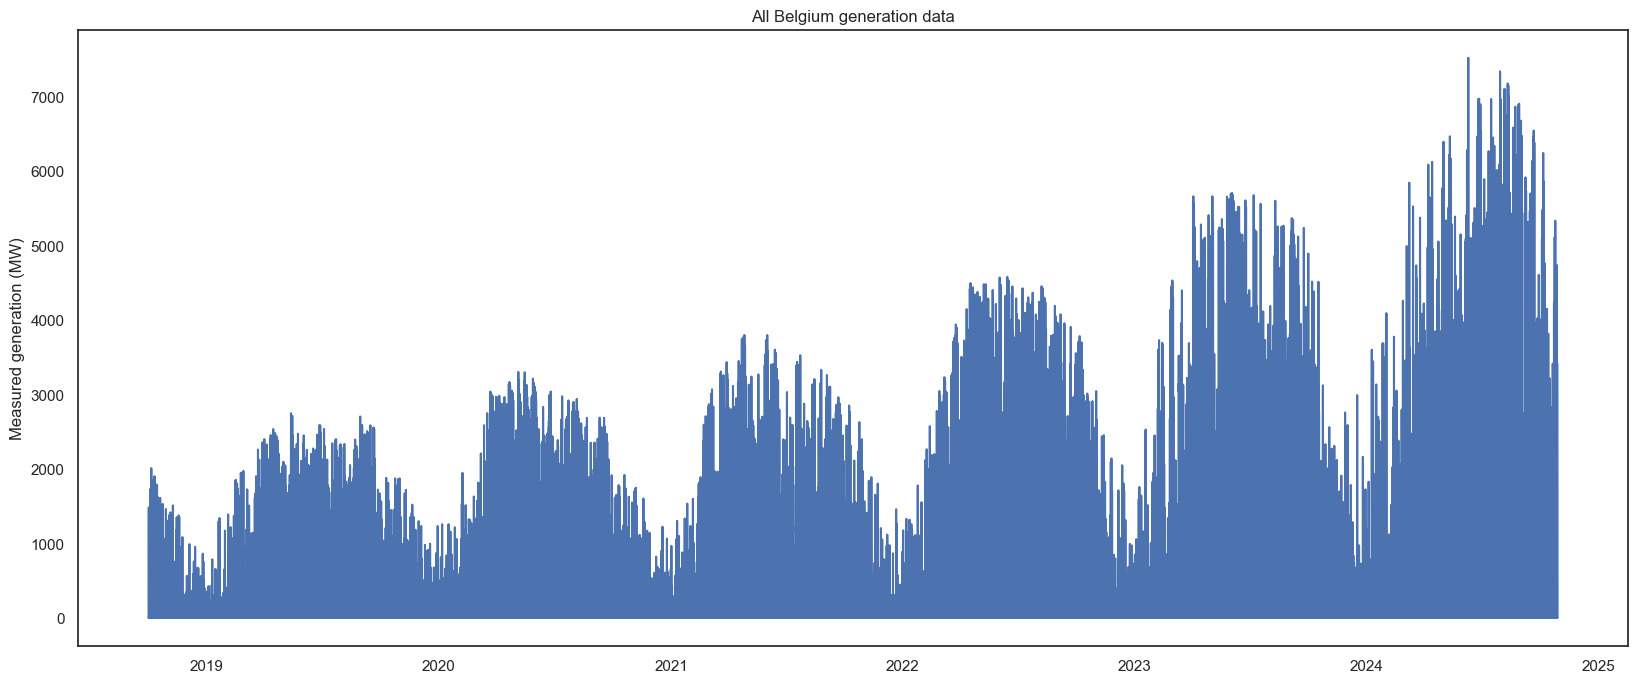

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be.measured)
plt.xlabel('')
plt.ylabel('Measured generation (MW)')
plt.title('All Belgium generation data')
plt.show()

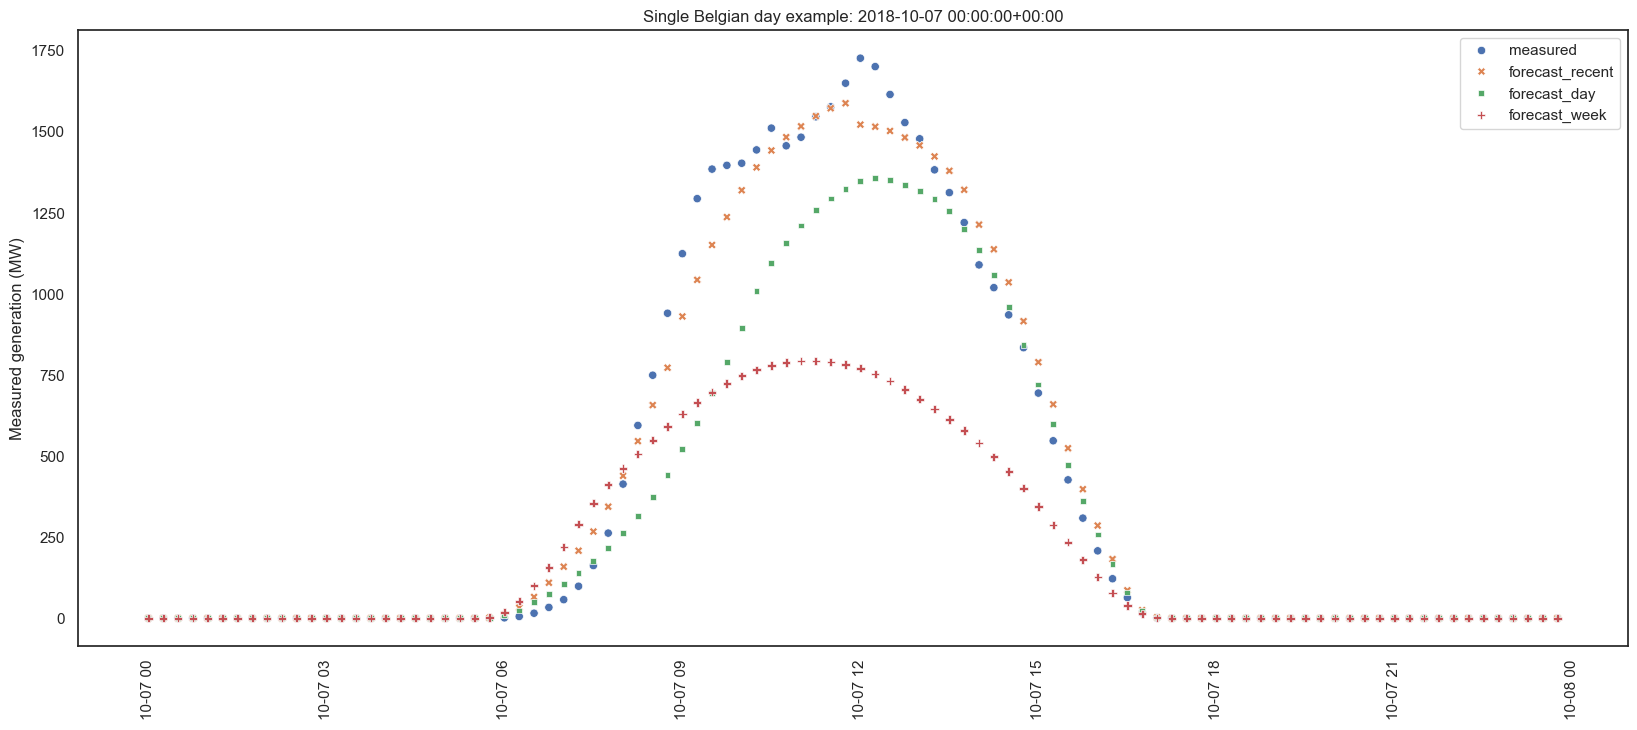

In [12]:
plt.figure(figsize=(20,8))
random_date = random.choice(df_be.index.normalize().unique())
sns.scatterplot(df_be[['measured','forecast_recent','forecast_day','forecast_week']][df_be.index.normalize() == random_date])
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Measured generation (MW)')
plt.title(f'Single Belgian day example: {random_date}')
plt.show()

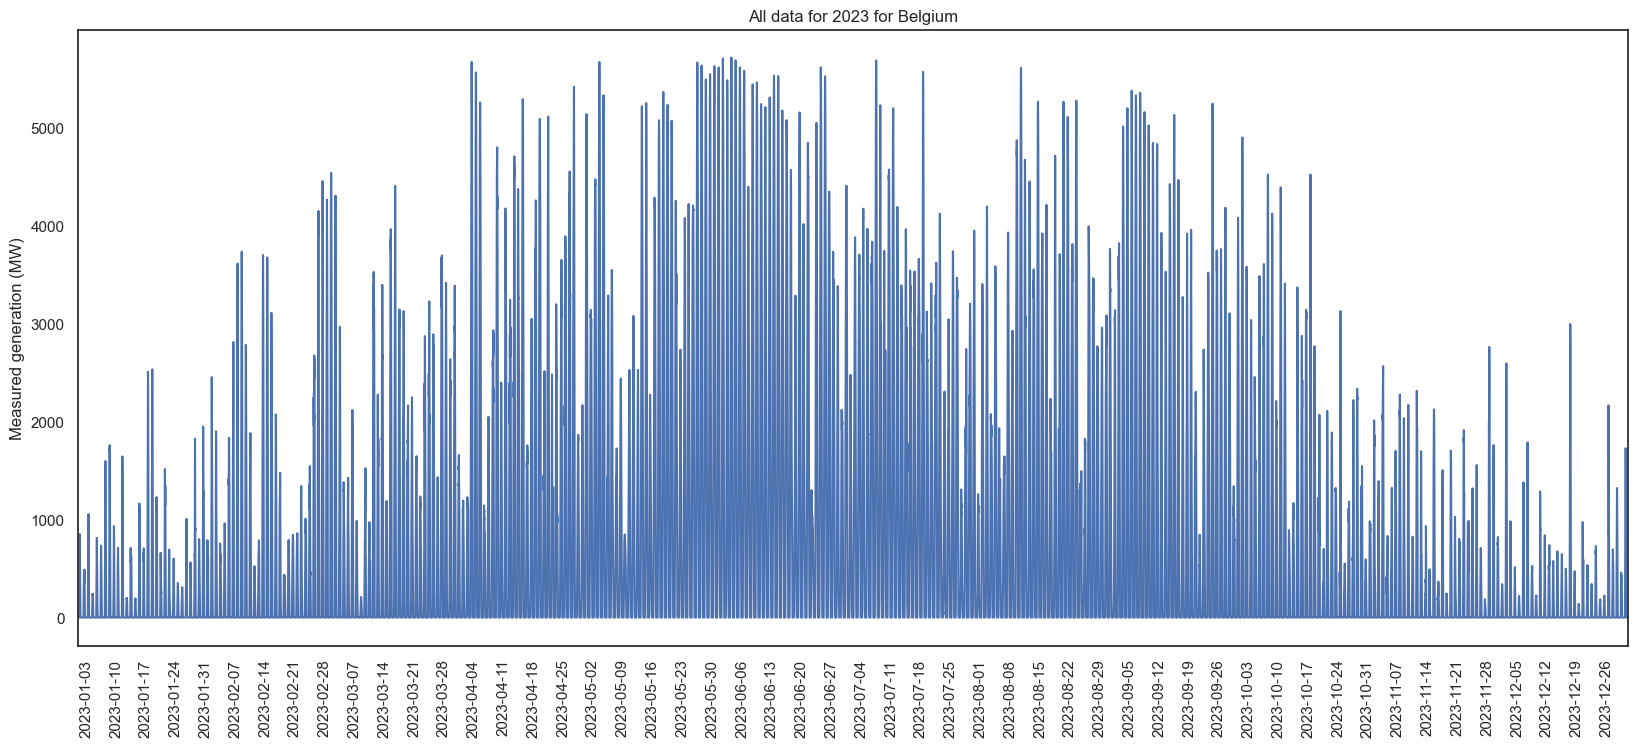

In [13]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation (MW)')
plt.title('All data for 2023 for Belgium')
plt.show()

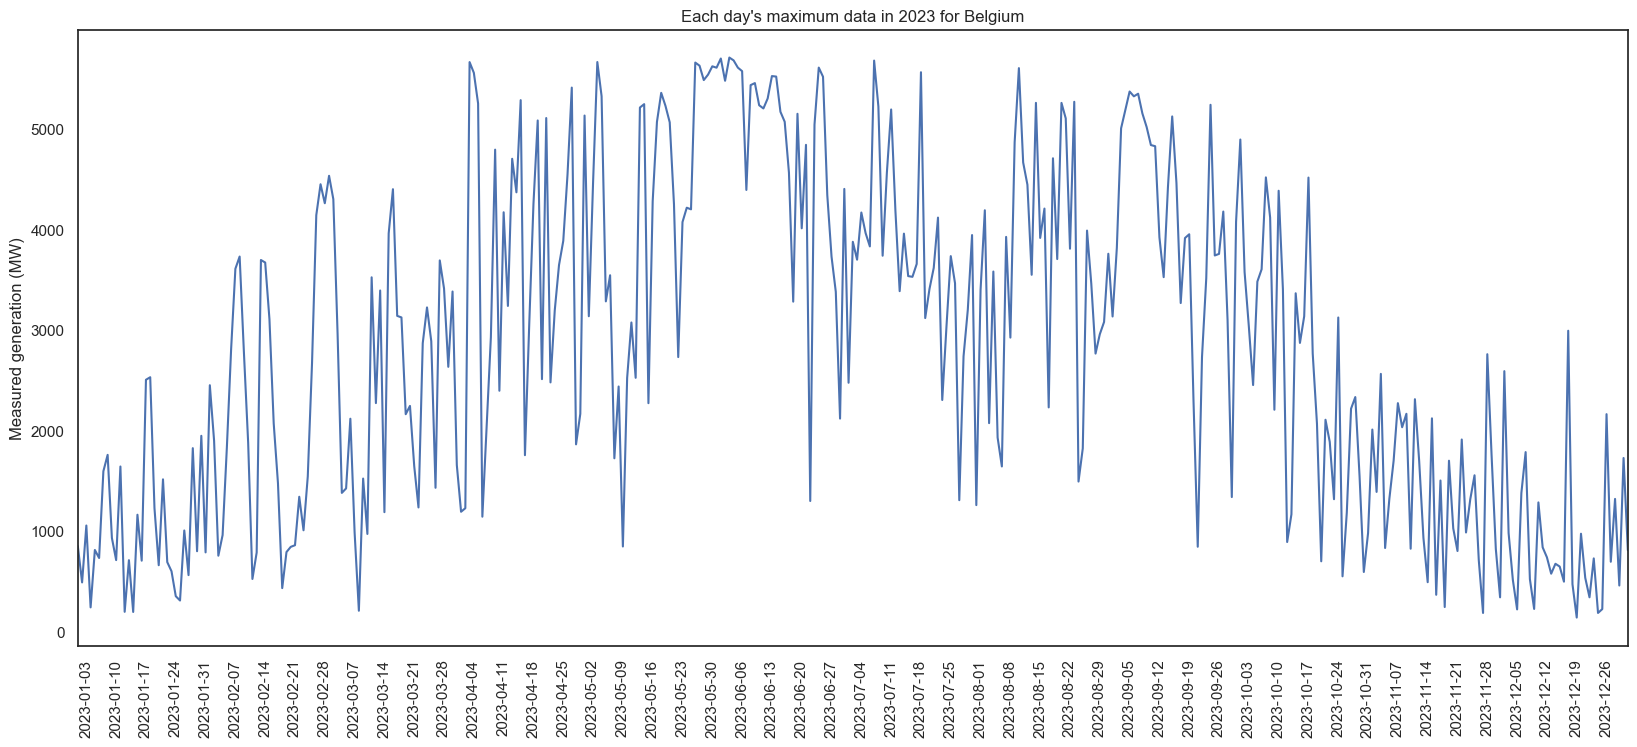

In [14]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.resample('D').max())
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation (MW)')
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

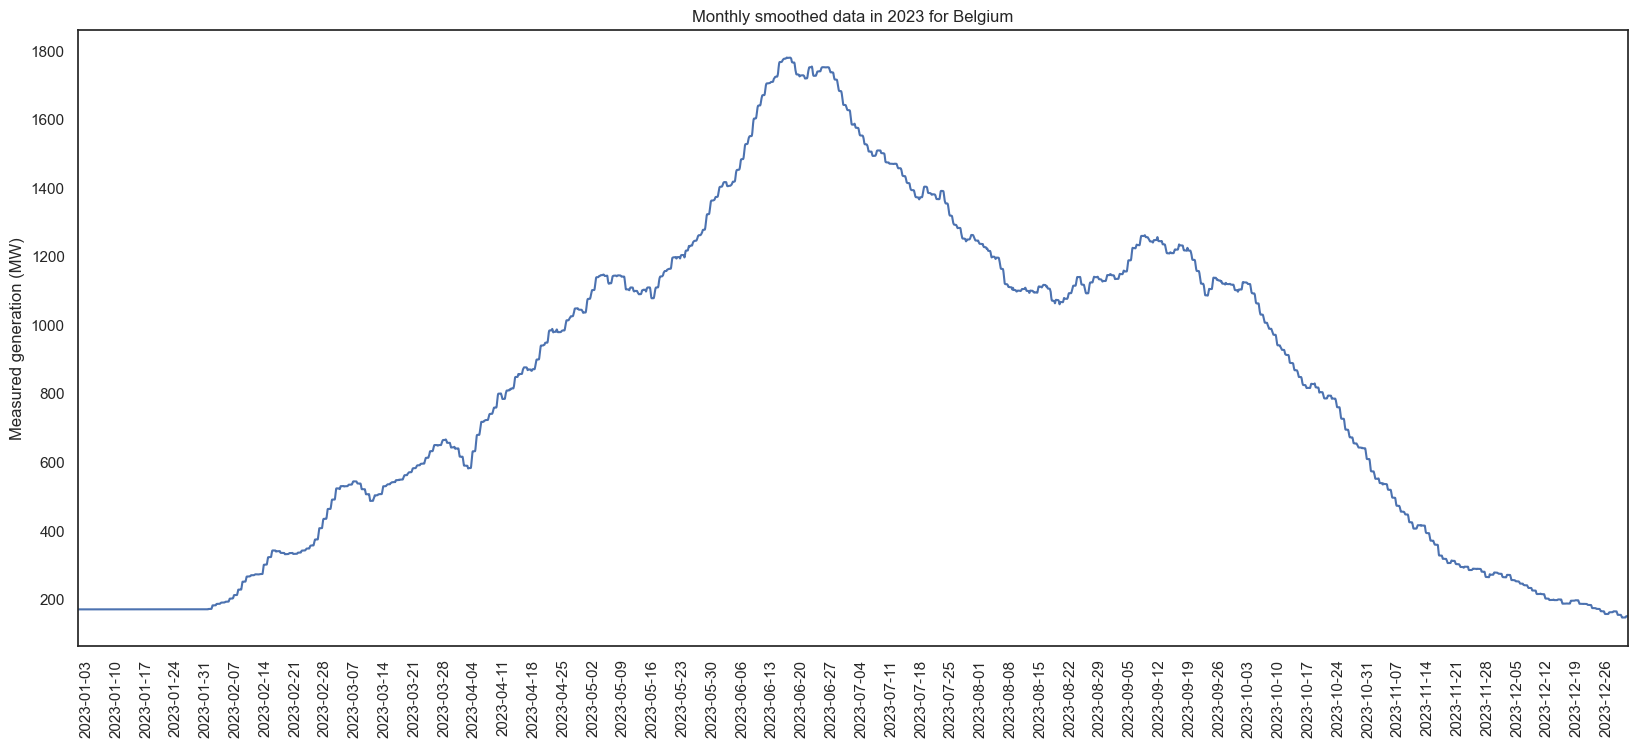

In [15]:
plt.figure(figsize=(20,8))
sns.lineplot(smooth_ma(df_be['2023-01-01':'2023-12-31'].measured,96*30))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation (MW)')
plt.title("Monthly smoothed data in 2023 for Belgium")
plt.show()

## Stats

In [16]:
var_stats(df_be.measured)

Coefficient of Variation	1.715
Interquartile Range (IQR)	898.792
Average Hourly Variation	62.569
Average Daily Variation		802.718
Average Monthly Variation	876.675


## Splitting by value

80-100:	3936
60-80:	14208
40-60:	40700
20-40:	76512
0-20:	77672


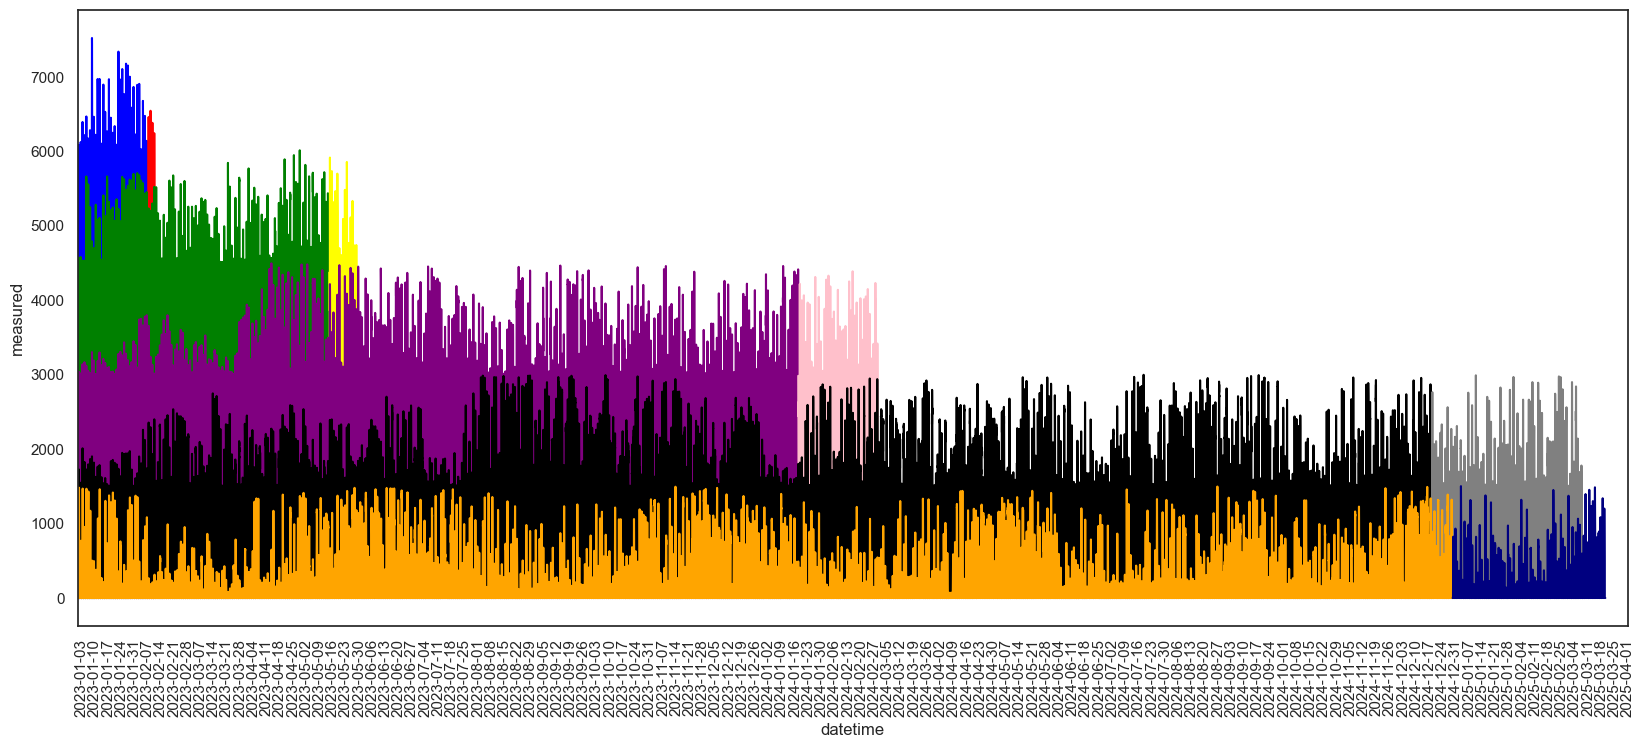

In [17]:
daily_max = df_be.measured.resample('D').max()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = df_be[df_be.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)
df_pc_80_100['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_80_100), freq="15min")
df_pc_80_100.set_index('datetime', inplace=True)
print(f'80-100:\t{len(df_pc_80_100)}')
split_pc_80_100 = math.floor(len(df_pc_80_100)*0.9)
df_pc_80_100_past = df_pc_80_100.iloc[:split_pc_80_100]
df_pc_80_100_future = df_pc_80_100.iloc[split_pc_80_100:]

df_pc_60_80 = df_be[df_be.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)
df_pc_60_80['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_60_80), freq="15min")
df_pc_60_80.set_index('datetime', inplace=True)
print(f'60-80:\t{len(df_pc_60_80)}')
split_pc_60_80 = math.floor(len(df_pc_60_80)*0.9)
df_pc_60_80_past = df_pc_60_80.iloc[:split_pc_60_80]
df_pc_60_80_future = df_pc_60_80.iloc[split_pc_60_80:]

df_pc_40_60 = df_be[df_be.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)
df_pc_40_60['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_40_60), freq="15min")
df_pc_40_60.set_index('datetime', inplace=True)
print(f'40-60:\t{len(df_pc_40_60)}')
split_pc_40_60 = math.floor(len(df_pc_40_60)*0.9)
df_pc_40_60_past = df_pc_40_60.iloc[:split_pc_40_60]
df_pc_40_60_future = df_pc_40_60.iloc[split_pc_40_60:]

df_pc_20_40 = df_be[df_be.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)
df_pc_20_40['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_20_40), freq="15min")
df_pc_20_40.set_index('datetime', inplace=True)
print(f'20-40:\t{len(df_pc_20_40)}')
split_pc_20_40 = math.floor(len(df_pc_20_40)*0.9)
df_pc_20_40_past = df_pc_20_40.iloc[:split_pc_20_40]
df_pc_20_40_future = df_pc_20_40.iloc[split_pc_20_40:]

df_pc_0_20 = df_be[df_be.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)
df_pc_0_20['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_0_20), freq="15min")
df_pc_0_20.set_index('datetime', inplace=True)
print(f'0-20:\t{len(df_pc_0_20)}')
split_pc_0_20 = math.floor(len(df_pc_0_20)*0.9)
df_pc_0_20_past = df_pc_0_20.iloc[:split_pc_0_20]
df_pc_0_20_future = df_pc_0_20.iloc[split_pc_0_20:]

plt.figure(figsize=(20,8))
sns.lineplot(df_pc_80_100_past.measured, color='blue')
sns.lineplot(df_pc_80_100_future.measured, color='red')
sns.lineplot(df_pc_60_80_past.measured, color='green')
sns.lineplot(df_pc_60_80_future.measured, color='yellow')
sns.lineplot(df_pc_40_60_past.measured, color='purple')
sns.lineplot(df_pc_40_60_future.measured, color='pink')
sns.lineplot(df_pc_20_40_past.measured, color='black')
sns.lineplot(df_pc_20_40_future.measured, color='grey')
sns.lineplot(df_pc_0_20_past.measured, color='orange')
sns.lineplot(df_pc_0_20_future.measured, color='navy')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-04-01'))
plt.show()

# Their forecasts

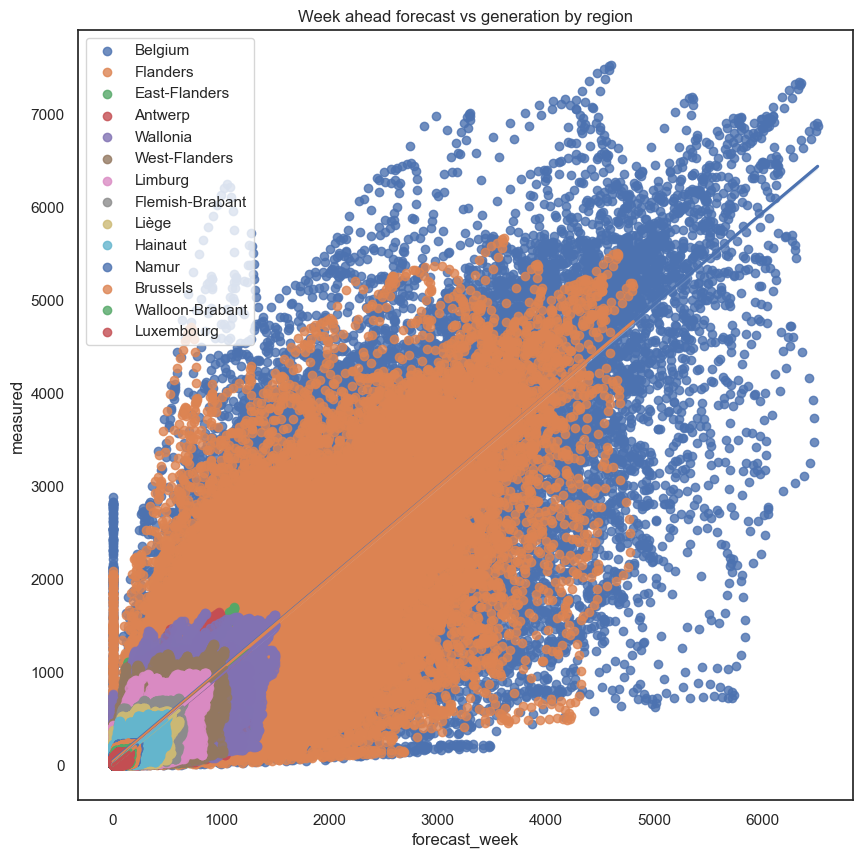

In [18]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Week ahead forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='forecast_week', label=region)
plt.legend(loc='upper left')
plt.savefig('week-ahead-forecast-vs-generation-by-region', bbox_inches='tight', transparent=True)
plt.show()

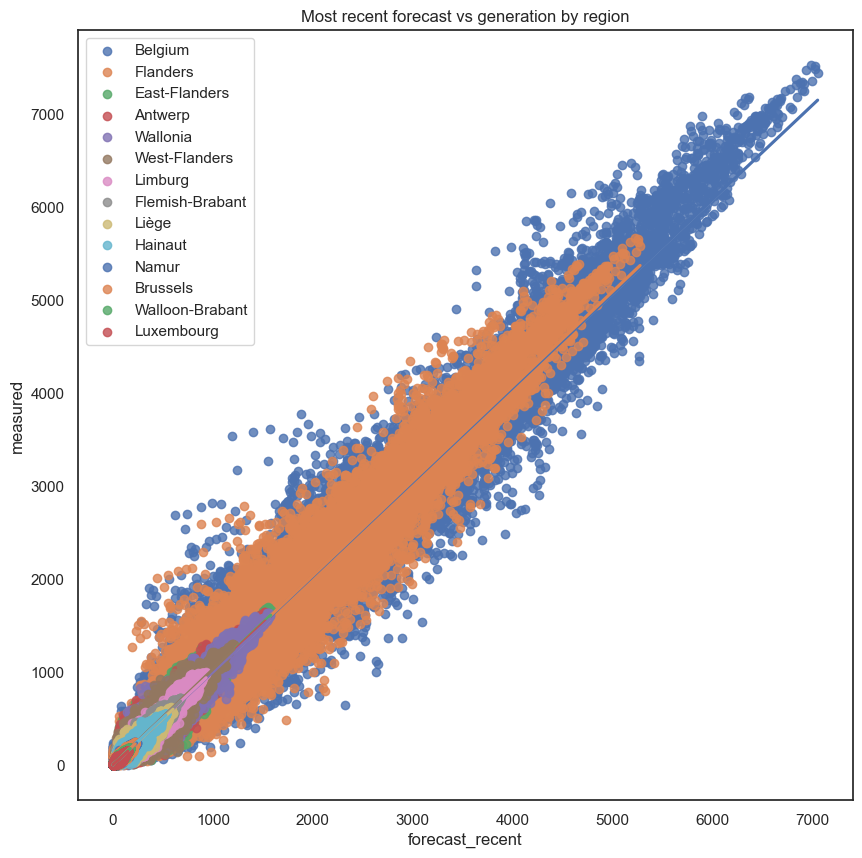

In [19]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Most recent forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='forecast_recent', label=region)
plt.legend(loc='upper left')
plt.savefig('most-recent-forecast-vs-generation-by-region', bbox_inches='tight', transparent=True)
plt.show()

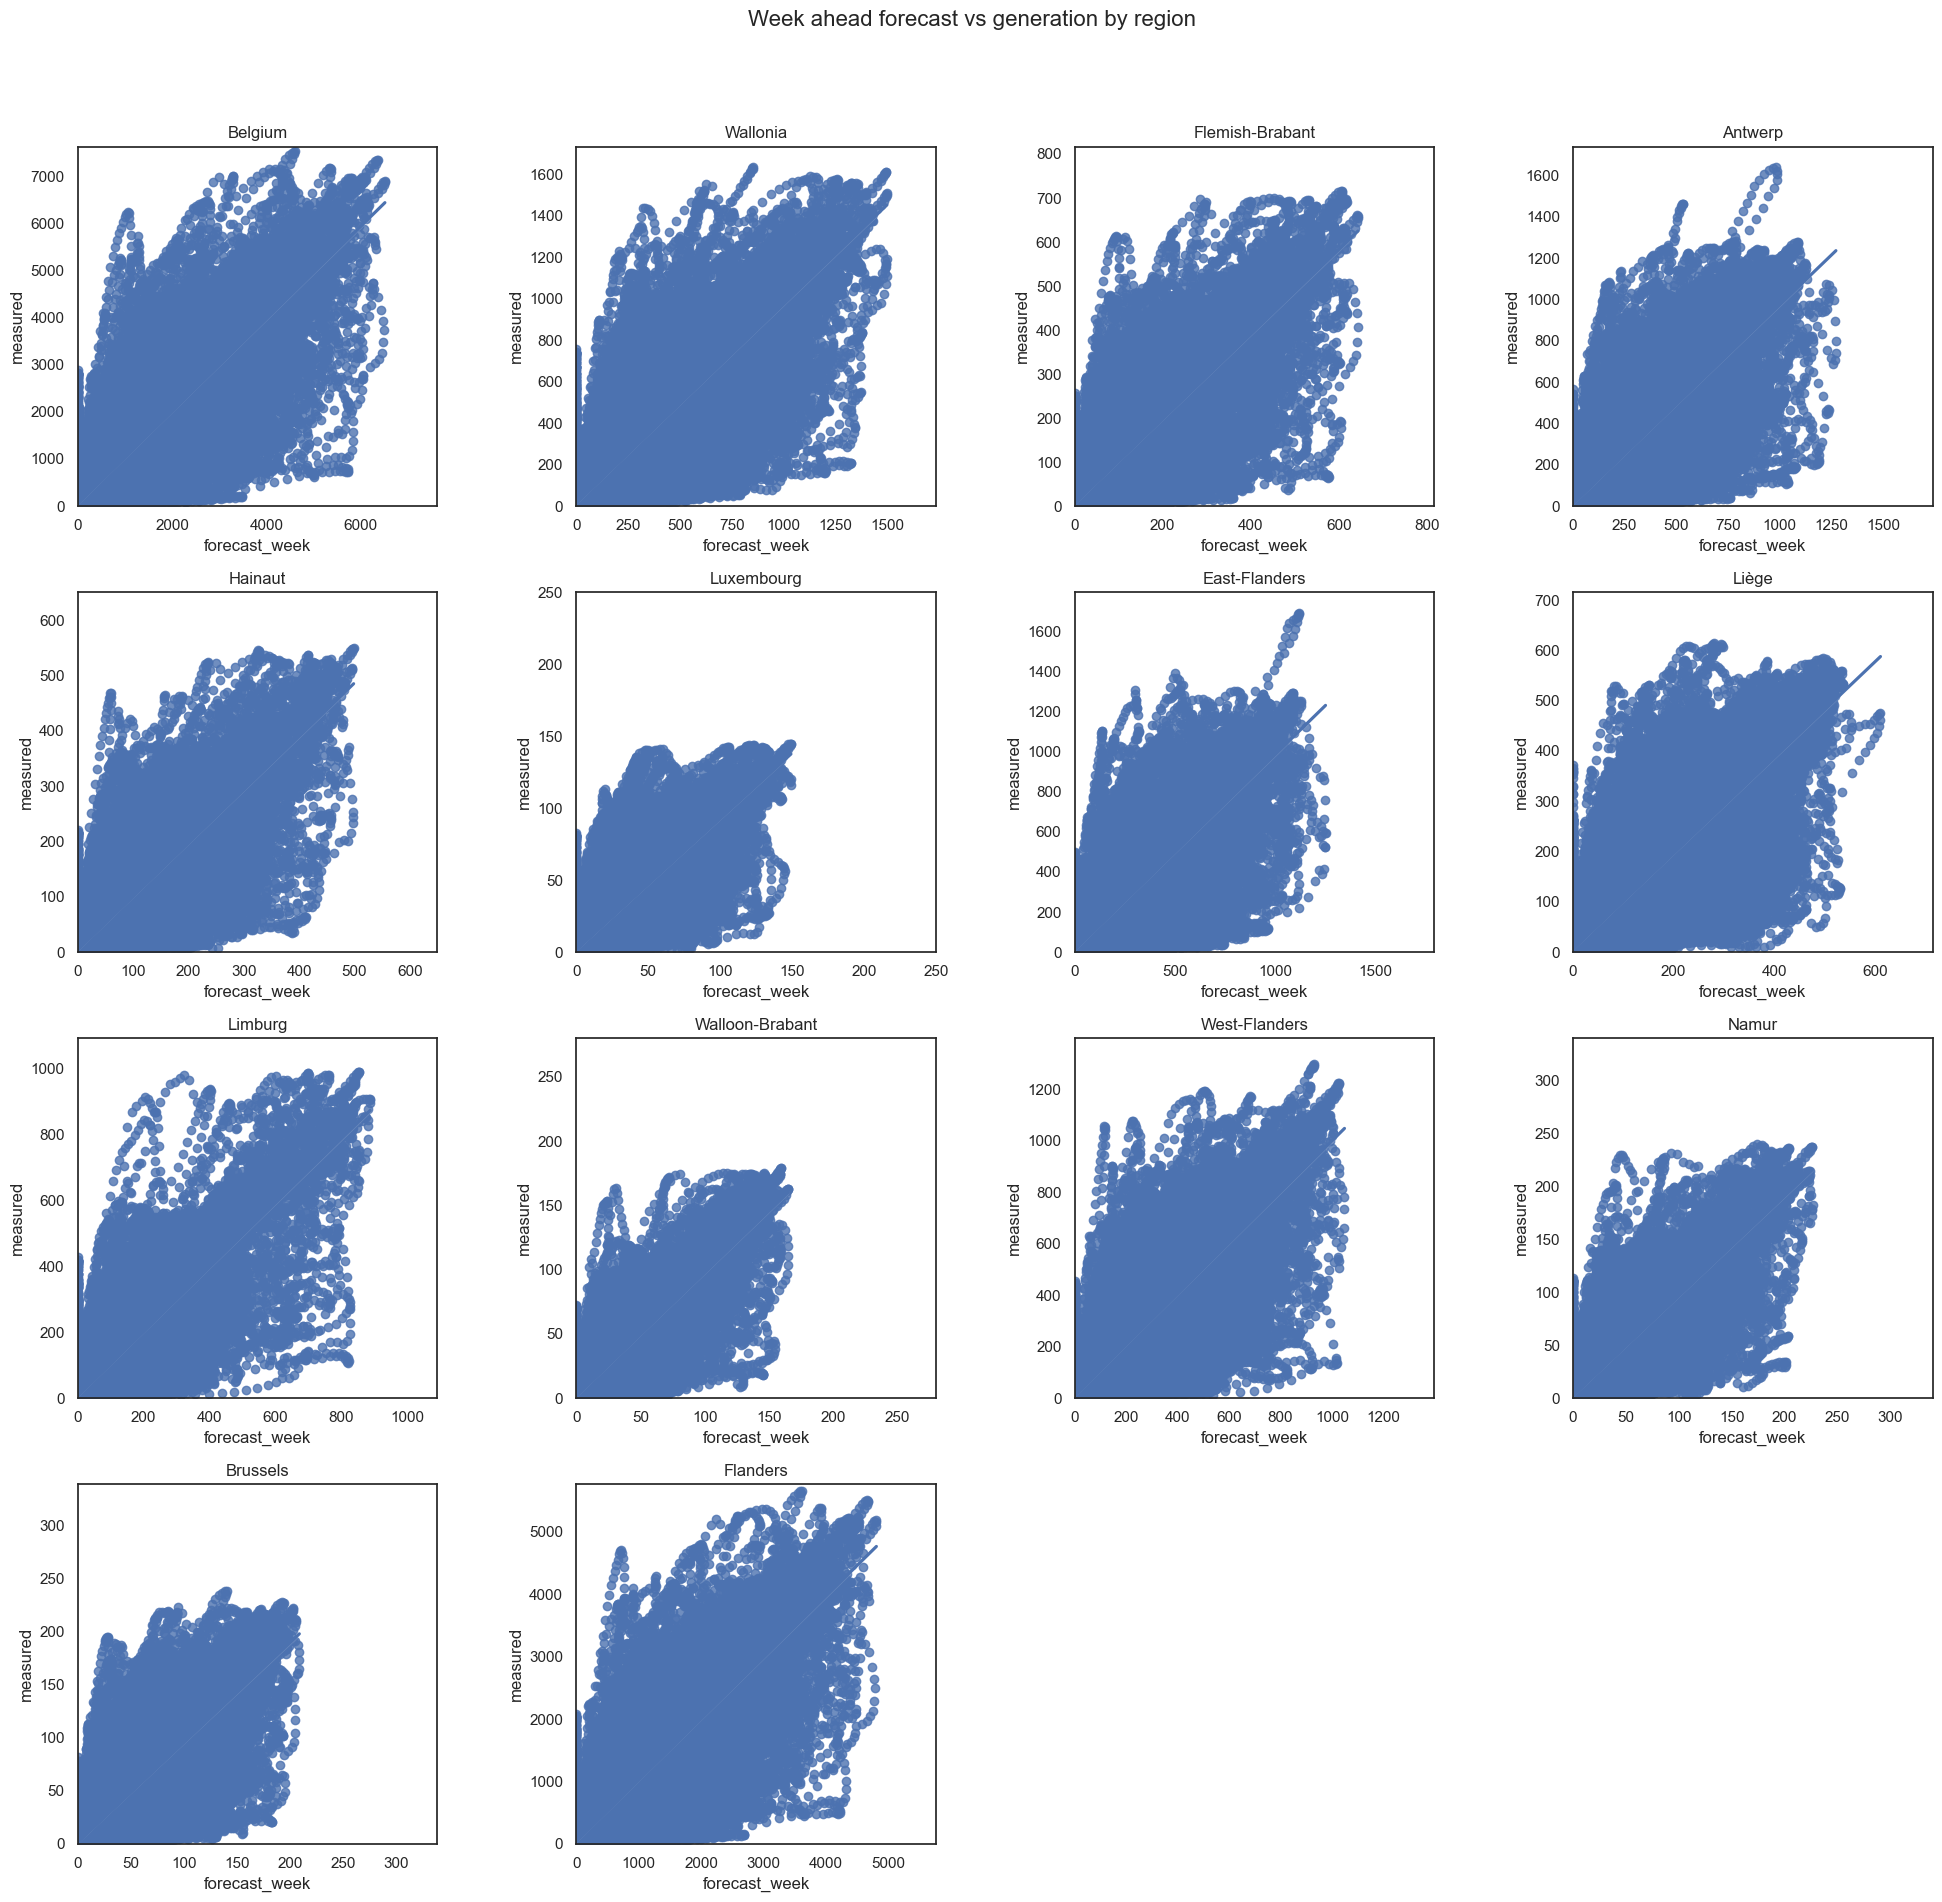

In [20]:
plt.figure(figsize=(20, 20))
plt.suptitle('Week ahead forecast vs generation by region', fontsize=16)

regions = df.region.unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    # print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = df[df.region == region]
    
    max_value = max(
        region_data.forecast_week.max(),
        region_data.measured.max()
    )
    max_limit = np.ceil(max_value)+100
    
    sns.regplot(data=region_data, 
                x='forecast_week', 
                y='measured')
    plt.title(region)
    plt.xlabel('forecast_week')
    plt.ylabel('measured')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('week-ahead-forecast-vs-generation-by-region-split', bbox_inches='tight', transparent=True)
plt.show()

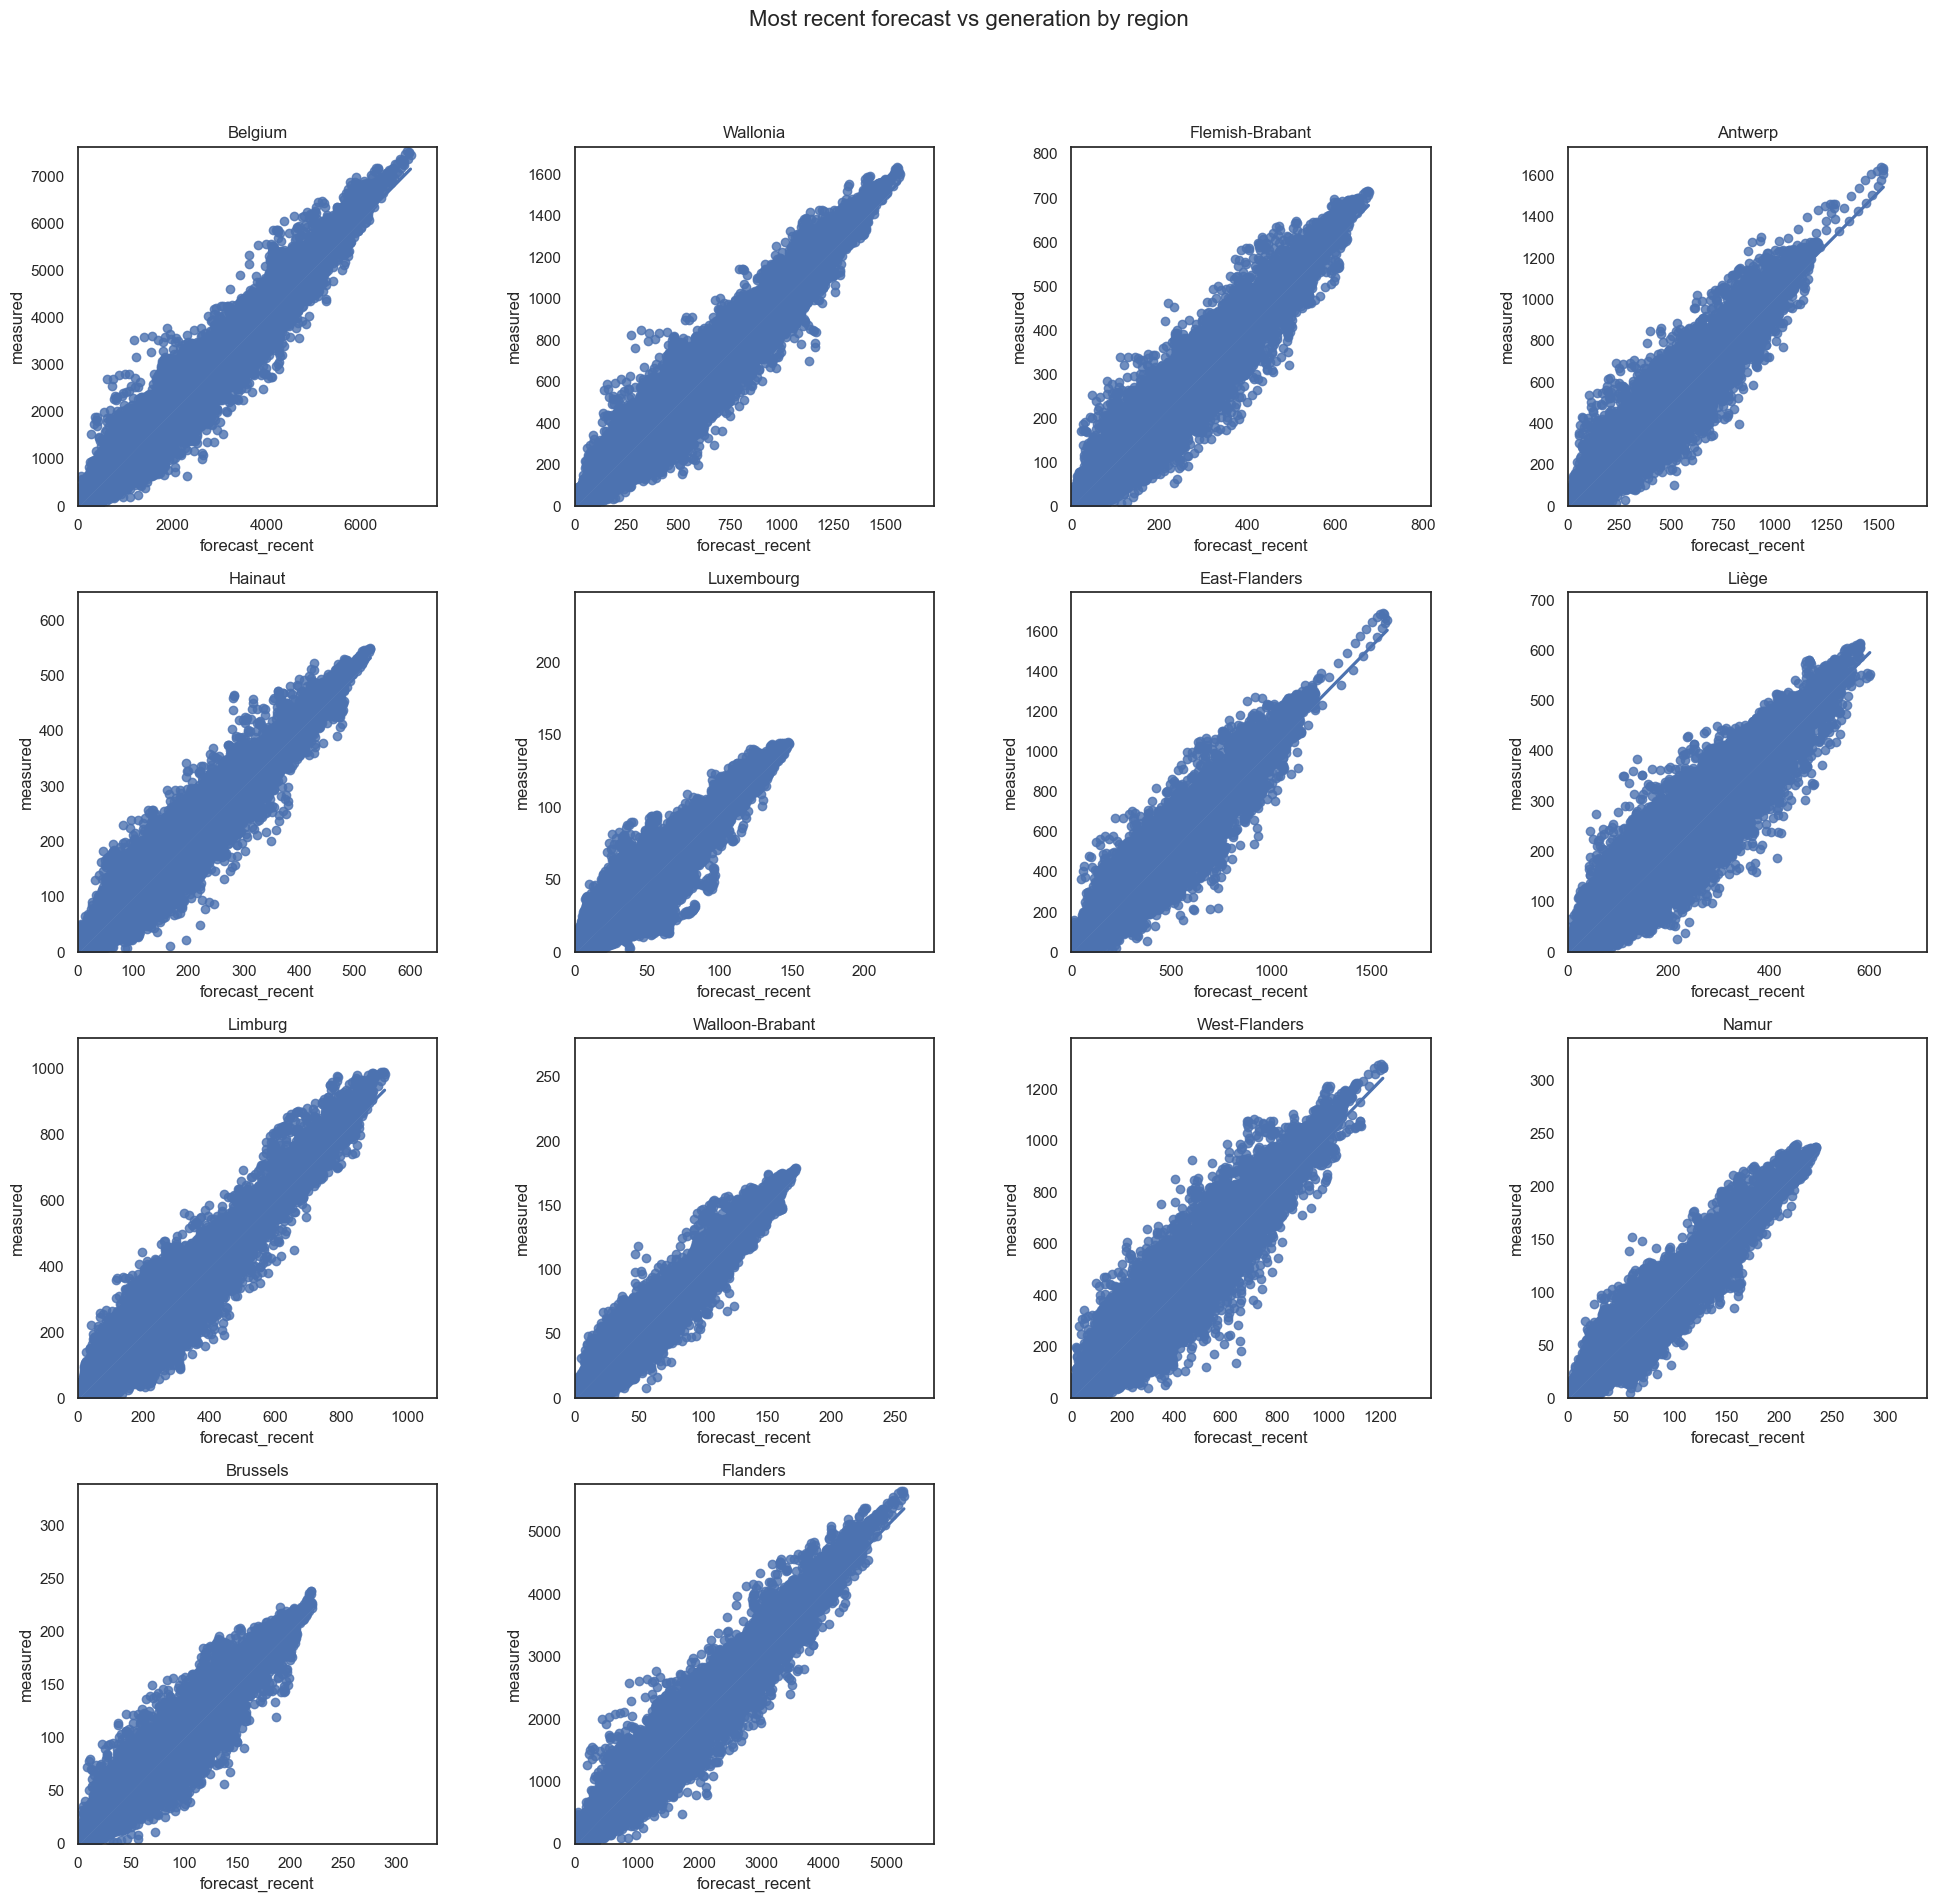

In [21]:
plt.figure(figsize=(20, 20))
plt.suptitle('Most recent forecast vs generation by region', fontsize=16)

regions = df.region.unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    # print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = df[df.region == region]
    
    max_value = max(
        region_data.forecast_recent.max(),
        region_data.measured.max()
    )
    max_limit = np.ceil(max_value)+100
    
    sns.regplot(data=region_data, 
                x='forecast_recent', 
                y='measured')
    plt.title(region)
    plt.xlabel('forecast_recent')
    plt.ylabel('measured')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('most-recent-forecast-vs-generation-by-region-split', bbox_inches='tight', transparent=True)
plt.show()

# Forecast errors

In [22]:
df_errs = df[['region','forecast_week','forecast_recent','measured']]
df_errs = df_errs[df_errs.measured != 0]
df_errs = df_errs.dropna()

df_errs['forecast_week_error'] = df_errs.measured - df_errs.forecast_week
df_errs['forecast_week_error_pc'] = np.divide(
    df_errs.forecast_week_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100
df_errs.forecast_week_error_pc = df_errs.forecast_week_error_pc.round(1)

df_errs['forecast_recent_error'] = df_errs.measured - df_errs.forecast_recent
df_errs['forecast_recent_error_pc'] = np.divide(
    df_errs.forecast_recent_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100
df_errs.forecast_recent_error_pc = df_errs.forecast_recent_error_pc.round(1)

df_errs = df_errs[['region','measured', 'forecast_week', 'forecast_week_error', 'forecast_week_error_pc', 'forecast_recent', 'forecast_recent_error', 'forecast_recent_error_pc']]

In [23]:
mean_errors_week = []
mean_errors_recent = []

for i, region in enumerate(df_errs.region.unique()):
    region_data = df_errs[df_errs.region == region]
    week_mean = int(abs(region_data.forecast_week).mean())
    week_mean_error = int(abs(region_data.forecast_week_error).mean())
    week_mean_error_pc = int(region_data.forecast_week_error_pc.mean())
    week_mae = int(mean_absolute_error(region_data.measured, region_data.forecast_week_error))
    week_mape = int(np.where(region_data.measured != 0, np.abs(region_data.forecast_week_error / region_data.measured) * 100, 0).mean())
    recent_mean = int(abs(region_data.forecast_recent_error).mean())
    recent_mean = int(abs(region_data.forecast_recent_error).mean())
    recent_mean_error_pc = int(region_data.forecast_recent_error_pc.mean())
    recent_mae = int(mean_absolute_error(region_data.measured, region_data.forecast_recent_error))
    recent_mape = int(np.where(region_data.measured != 0, np.abs(region_data.forecast_recent_error / region_data.measured) * 100, 0).mean())

    mean_errors_week.append({'region': region, 'Measured': week_mean, 'Error': week_mean_error, '% Error': week_mean_error_pc, 'MAE': week_mae, 'MA%E': week_mape})
    mean_errors_recent.append({'region': region, 'Measured': recent_mean, 'Error': recent_mean, '% Error': recent_mean_error_pc, 'MAE': recent_mae, 'MA%E': recent_mape})

mean_errors_week_df_errs = pd.DataFrame(mean_errors_week)
mean_errors_week_df_errs = mean_errors_week_df_errs.sort_values(by='MA%E', ascending=True)
mean_errors_recent_df_errs = pd.DataFrame(mean_errors_recent)
mean_errors_recent_df_errs = mean_errors_recent_df_errs.sort_values(by='MA%E', ascending=True)

print('Mean absolute values, forecast (period) vs actual generation, all years, by region')
print('Week ahead forecast')
display(mean_errors_week_df_errs)
print()
print('Most recent forecast')
display(mean_errors_recent_df_errs)

Mean absolute values, forecast (period) vs actual generation, all years, by region
Week ahead forecast


region  Measured  Error  % Error   MAE  MA%E
2        Luxembourg        29     10     -113    29   145
1   Walloon-Brabant        26     10     -115    26   149
9          Wallonia       287    103     -119   287   153
0             Liège       112     43     -145   112   179
4             Namur        39     15     -147    39   181
12         Brussels        27     11     -151    27   185
13          Hainaut        84     32     -162    84   196
8           Limburg       142     55     -172   142   207
5   Flemish-Brabant       106     42     -175   106   210
10    East-Flanders       214     85     -210   214   245
7           Belgium      1168    430     -229  1168   263
11    West-Flanders       192     77     -234   192   270
6           Antwerp       212     85     -241   212   275
3          Flanders       857    324     -325   857   360


Most recent forecast


region  Measured  Error  % Error   MAE  MA%E
1   Walloon-Brabant         3      3      -47    27    64
9          Wallonia        30     30      -53   301    69
2        Luxembourg         4      4      -57    30    74
12         Brussels         3      3      -63    28    80
4             Namur         5      5      -65    41    81
0             Liège        15     15      -67   118    85
8           Limburg        19     19      -84   151   101
13          Hainaut        10     10      -86    88   102
5   Flemish-Brabant        13     13      -88   111   104
6           Antwerp        27     27     -113   224   130
7           Belgium       120    120     -121  1229   137
10    East-Flanders        28     28     -129   225   146
11    West-Flanders        29     29     -142   202   162
3          Flanders        94     94     -195   903   212

In [25]:
mean_errors = []


df_errs['year'] = df_errs.index.year
df_errs_filtered = df_errs[(df_errs.year >= 2019) & (df_errs.year <= 2022)]

for year in df_errs_filtered.year.unique():
    year_data = df_errs_filtered[df_errs_filtered.year == year]
    week_mean = int(abs(year_data.forecast_week).mean())
    week_mean_error = int(abs(year_data.forecast_week_error).mean())
    week_mean_error_pc = int(year_data.forecast_week_error_pc.mean())
    week_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_week_error))
    week_mape = int(np.where(year_data.measured != 0, np.abs(year_data.forecast_week_error / year_data.measured) * 100, 0).mean())
    recent_mean = int(abs(year_data.forecast_recent).mean())
    recent_mean_error = int(abs(year_data.forecast_recent_error).mean())
    recent_mean_error_pc = int(year_data.forecast_recent_error_pc.mean())
    recent_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_recent_error))
    recent_mape = int(np.where(year_data.measured != 0, np.abs(year_data.forecast_recent_error_pc / year_data.measured) * 100, 0).mean())
    mean_errors.append({
        'Year': year,
        'Week Measured': week_mean,
        'Week Error': week_mean_error,
        'Week % Error': week_mean_error_pc,
        'Week MAE': week_mae,
        'Week MA%E': week_mape,
        'Recent Measured': recent_mean,
        'Recent Error': recent_mean_error,
        'Recent % Error': recent_mean_error_pc,
        'Recent MAE': recent_mae,
        'Recent MA%E': recent_mape
    })

mean_errors_df_errs = pd.DataFrame(mean_errors)
mean_errors_df_errs = mean_errors_df_errs.melt(id_vars='Year', var_name='Error', value_name='Value')
mean_errors_df_errs = mean_errors_df_errs.pivot(index='Error', columns='Year', values='Value')
mean_errors_df_errs = mean_errors_df_errs.reindex(['Week Measured', 'Week Error', 'Week % Error', 'Week MAE', 'Week MA%E', 'Recent', 'Recent Error', 'Recent % Error', 'Recent MAE', 'Recent MA%E'])

print('Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year')
display(mean_errors_df_errs)

Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year


Year                 2019       2020       2021       2022
Error                                                     
Week Measured       160.0      193.0      195.0      270.0
Week Error           55.0       63.0       80.0      102.0
Week % Error       -150.0     -151.0     -141.0     -115.0
Week MAE            160.0      193.0      195.0      270.0
Week MA%E           179.0      179.0      180.0      153.0
Recent                NaN        NaN        NaN        NaN
Recent Error         21.0       23.0       27.0       28.0
Recent % Error      -87.0      -67.0      -66.0      -75.0
Recent MAE          170.0      199.0      216.0      303.0
Recent MA%E     3404343.0  2834165.0  3042062.0  3138066.0

In [26]:
total_non_zero = df_errs.measured[df_errs.measured != 0].count()
print(f'Total non-zero data\t\t{total_non_zero:,}')
print(f'Week forecast error positive:\t{int((df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc > 0].count())/total_non_zero*100)}%')
print(f'Week forecast error negative:\t{int((df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc < 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error positive:\t{int((df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc > 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error negative:\t{int((df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc < 0].count())/total_non_zero*100)}%')


Total non-zero data		1,530,969
Week forecast error positive:	53%
Week forecast error negative:	46%
Recent forecast error positive:	46%
Recent forecast error negative:	52%


Recent forecast error statistics
Mean:		265
Median:		72
Std dev:	558
IQR:		229
MAD:		98


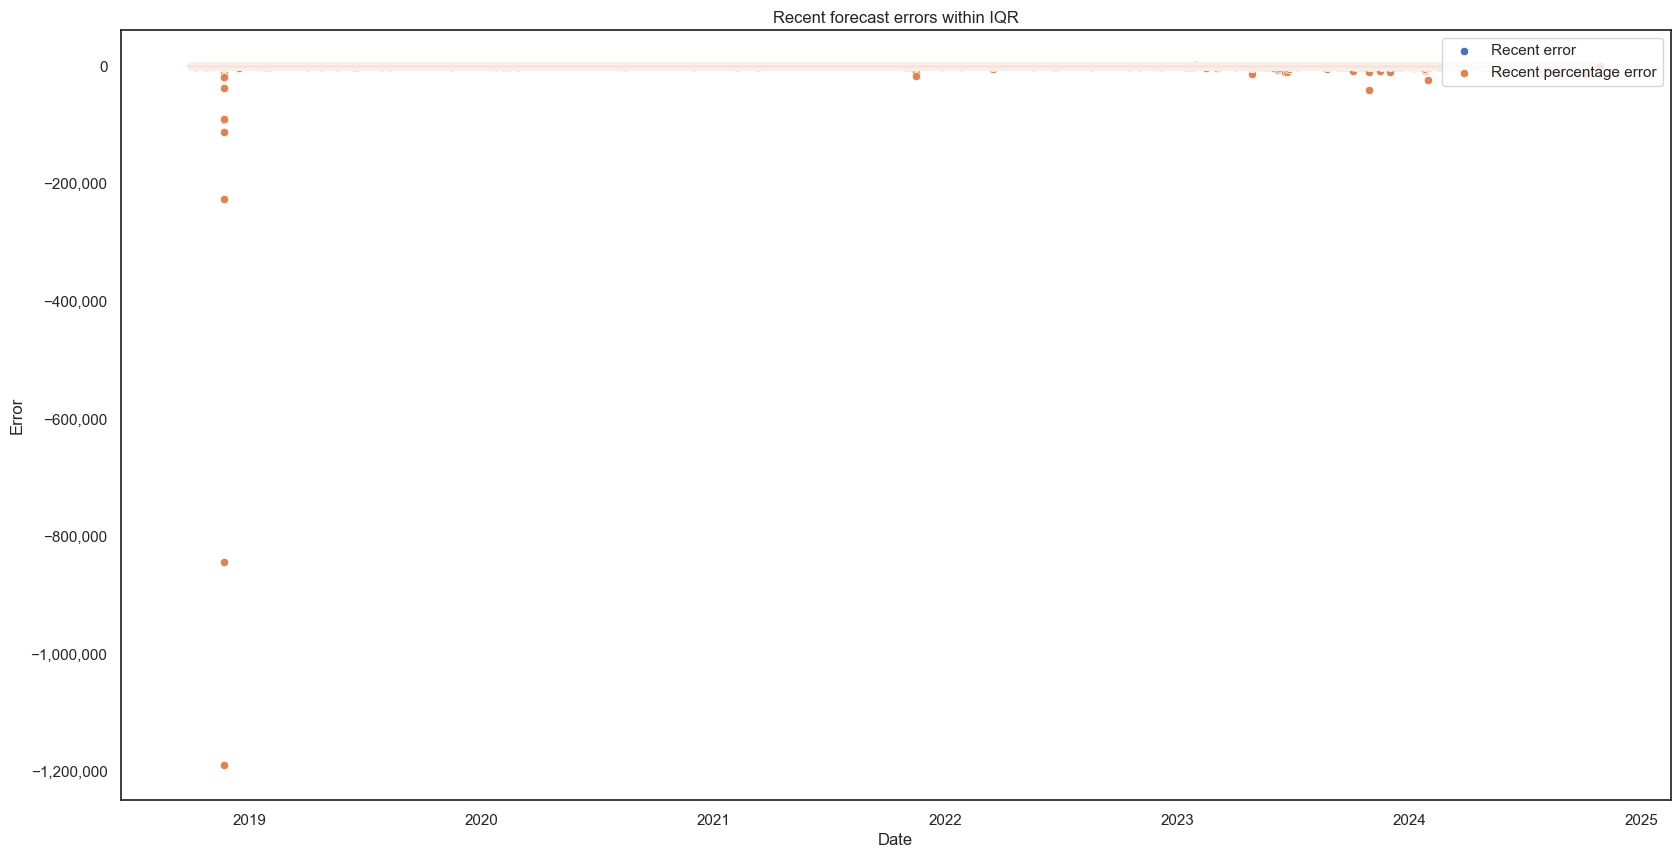

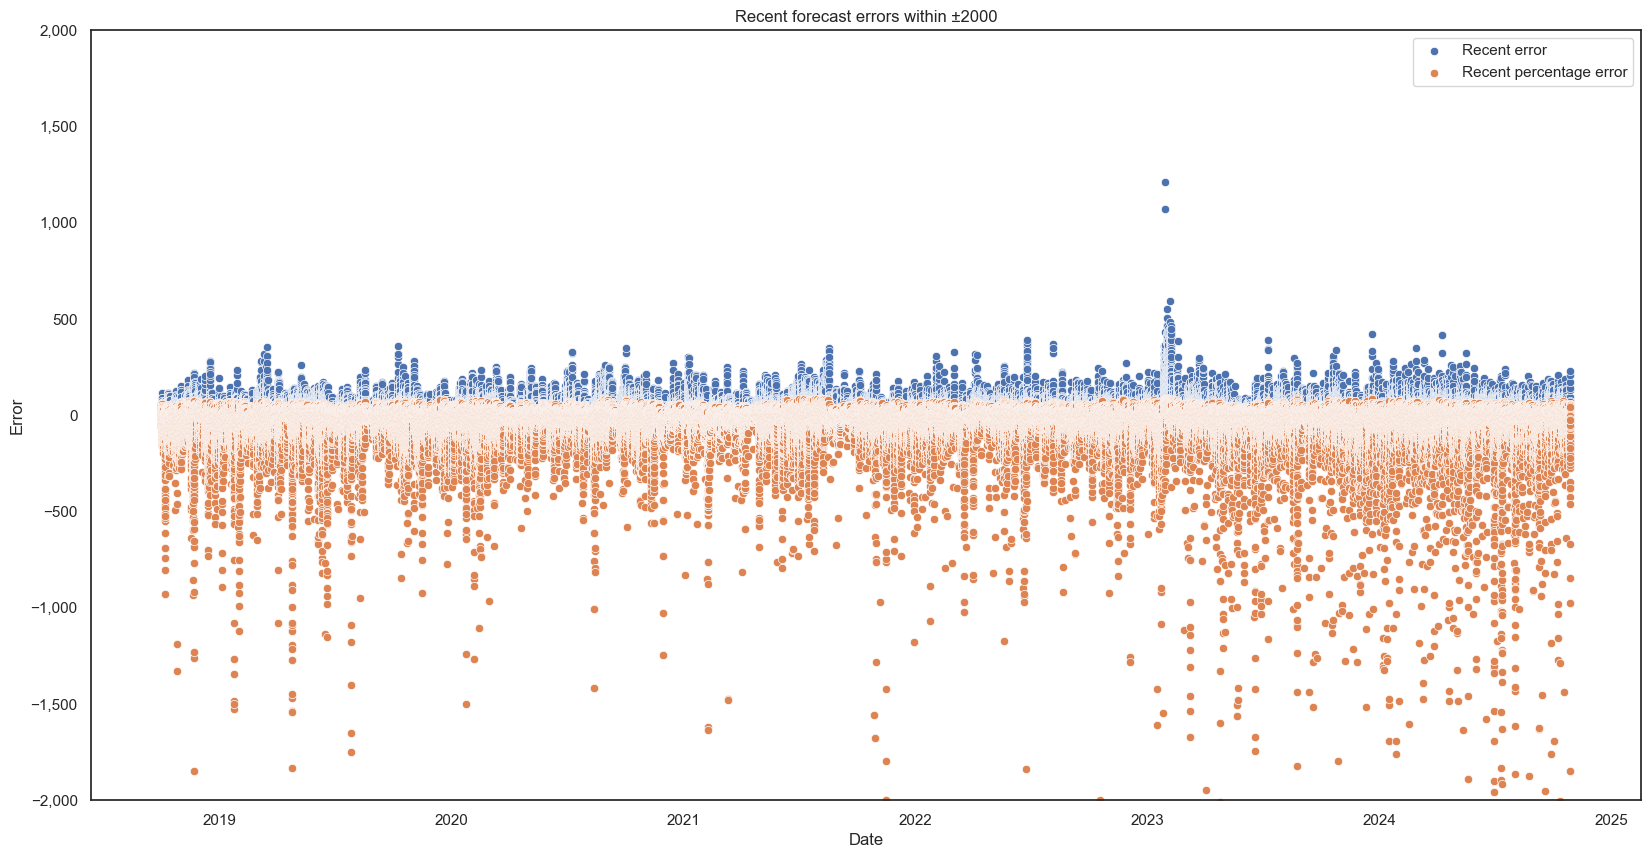

In [27]:
print('Recent forecast error statistics')
stats_errs = df_errs.forecast_recent.agg(['mean', 'median', 'std'])
print(f"Mean:\t\t{int(stats_errs.get('mean'))}")
print(f"Median:\t\t{int(stats_errs.get('median'))}")
print(f"Std dev:\t{int(stats_errs.get('std'))}")
q1 = df_errs.forecast_recent.quantile(0.25)
q3 = df_errs.forecast_recent.quantile(0.75)
print(f"IQR:\t\t{int(q3-q1)}")
print(f"MAD:\t\t{int(mad(df_errs.forecast_recent))}")

df_errs_iqr = df_errs[(df_errs.forecast_recent >= q1) & (df_errs.forecast_recent <= q3)]

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within IQR')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within ±2000')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.ylim(-2000,2000)
plt.show()

# Modelling

In [7]:
start = '2023-01-01'
back = 7
pred = 7
sm = 4
sa = 4
m = int(96/4/sa)
arima_file_title = f'belgium_{start}_{back}d_{pred}d_arima_sm{sm}sa{sa}'
tf_file_title = f'belgium_{start}_{back}d_{pred}d_tf'
arima_plot_title = f'TF Belgium, {back}d history, {pred}d forward (sm{sm}sa{sa})'
tf_plot_title = f'TF Belgium, {back}d history, {pred}d forward'

## ARIMA

In [8]:
df_be_arima = df_be[['measured','forecast_week']].copy()

In [9]:
def plot_input(df_in):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_in.measured, color = 'black', label='Actual')
    plt.show()

def plot_pred(df_pred, df_f_in, title=''):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_f_in.measured, color = 'black', label='Actual')
    sns.lineplot(df_f_in.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
    sns.lineplot(df_pred[0], color = 'red', label='My forecast')
    sns.despine()
    plt.xlabel('')
    plt.ylabel('Generation (MW)')
    plt.legend()
    plt.title(arima_plot_title)
    plt.savefig(f'{arima_file_title}', bbox_inches='tight', transparent=True)
    plt.show()

def run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sa=4, sm=4, m=6, trace=True, stats=True, plot=True, plot_amount='all', save=False, title=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]
    df_fwd = df_in[start_date:end_forward]
    df_all = df_in[start_backward:end_forward]

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
            df_f, _, _ = resample_m(df_fwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
            df_f, _, _ = resample_h(df_fwd, sa)
    elif reduce == 'smooth':
        df_run = smooth_ma(df_bwd, sm)
        df_f = df_fwd
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        df_run, daily_samples, r = resample_h(smooth_ma(df_bwd, sm), sa)
        df_f, _, _ = resample_h(smooth_ma(df_fwd, sm), sa)
    elif reduce == 'none':
        df_run = df_bwd
        df_f = df_fwd
        daily_samples = 96
        r = 'N/A'
    del _
    
    pred_periods = int(daily_samples*pred)

    if reduce == 'sample':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'smooth':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'both':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'none':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')

    # plot_input(df_run)

    if trace:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, trace=True)
    else:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True)
    
    df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
    df_auto_pred = df_auto_pred.clip(lower=0)
    # df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=sa/2) # to centralise samples

    if stats:
        print()
        display(jgstats(df_auto_pred, df_f))

    if plot:
        if plot_amount == 'all':
            plot_pred(df_auto_pred, df_all, title)
        elif plot_amount == 'future':
            plot_pred(df_auto_pred, df_f, title)

    if save:
        with open(f'{title}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    return model_auto, df_auto_pred

7 days of data, from 2022-12-25 to 2022-12-31
smoothed at 4x, then sampled at 4h, giving 42 values (6/day)
with a seasonal period of 6 (1 days)
with 42 predictons (7 days), until 2023-01-07


Mean		69.65
Median		0.15
Mode		0.0
Std Dev		100.73
Mean Error	60.44
Median Error	0.0
Mode Error	0.0
Error Std Dev	137.06
Max Error	572.44
MAE		67.72
MSE		21990.7
RMSE		148.29
MA%E		95.1
R²		0.51


None

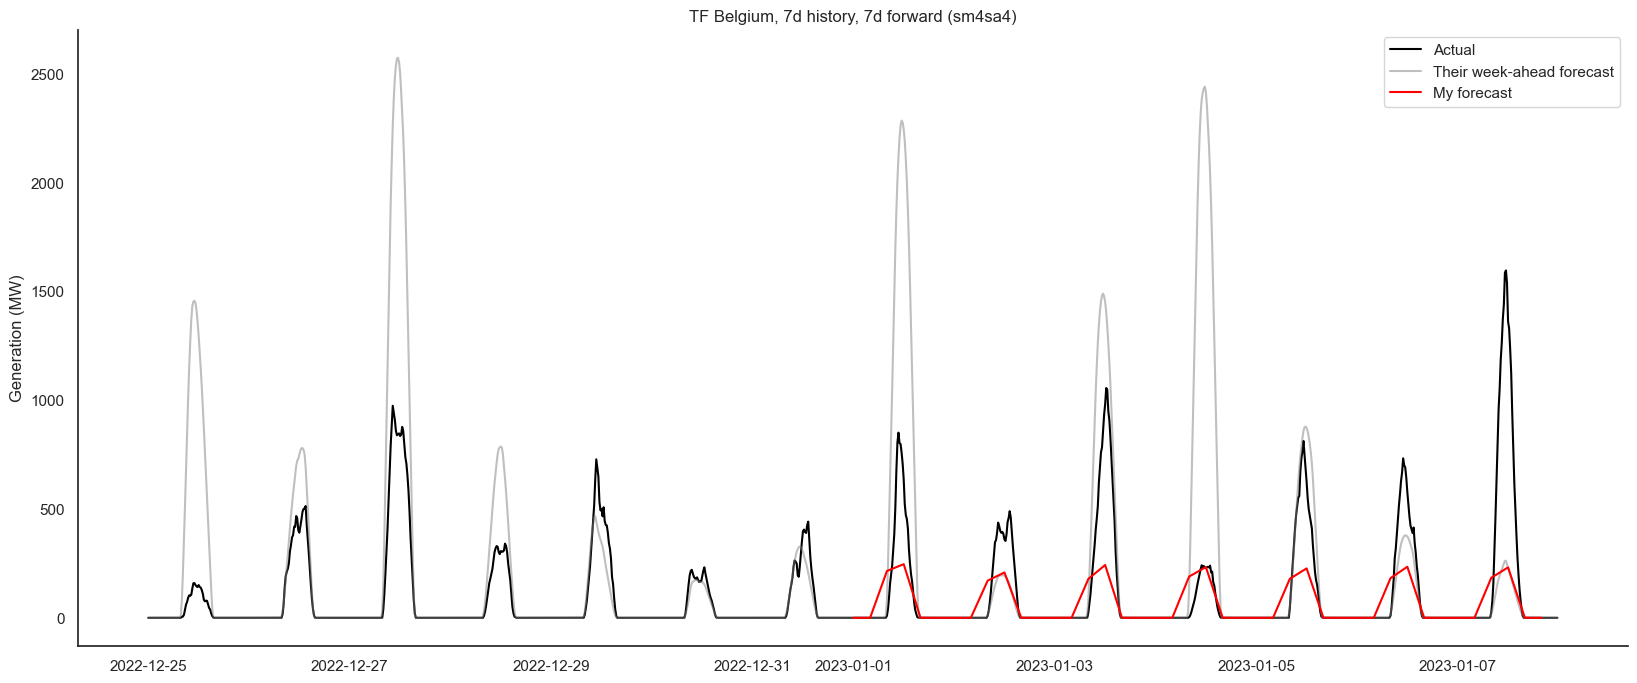

In [10]:
model_arima, pred_arima = run_model(df_in=df_be_arima, start=start, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, trace=False, stats=True, plot=True, plot_amount='all', save=True, title=arima_file_title)

### Sliding window cross validation

In [11]:
# def create_sequences(data, seq_len):
#     """
#     Create input-output pairs for time series data for an LSTM model.
    
#     Parameters:
#     - data: Array-like time series data.
#     - seq_len: Length of each input sequence.
    
#     Returns:
#     - X: Array of input sequences of shape (num_samples, seq_len, 1).
#     - y: Array of target values of shape (num_samples, 1).
#     """
#     X, y = [], []
    
#     for i in range(len(data) - seq_len):
#         X.append(data[i:i + seq_len])
#         y.append(data[i + seq_len])
    
#     # Convert to numpy arrays and reshape for LSTM input
#     X = np.array(X).reshape(-1, seq_len, 1)
#     y = np.array(y).reshape(-1, 1)
    
#     return X, y
    
# df_be_arima_swcv = df_be_arima['2023-01-01':'2023-12-31']

# train_window = 4 * 7 * 96
# test_window = 7 * 96

# errors = []

# for start in range(0, len(df_be_arima_swcv) - train_window - test_window, test_window):
#     train_data = df_be_arima_swcv.measured.values[start : start + train_window]
#     test_data = df_be_arima_swcv.measured.values[start + train_window : start + train_window + test_window]

#     X_train, y_train = create_sequences(train_data, seq_len)
#     X_test, y_test = create_sequences(test_data, seq_len)

#     model_arima.fit(X_train, y_train)
#     predictions = model_arima.predict(X_test)

#     error = mean_squared_error(y_test, predictions)
#     errors.append(error)

# print("Average Cross-Validation Error:", np.mean(errors))

## Keras

### Setup

In [12]:
# start = '2023-01-01'
# back = 7
# pred = 7
# tf_file_title = 'tf_belgium_20230101_1wk_1wk'
# tf_plot_title = 'TF Belgium, one week history, one week forward'

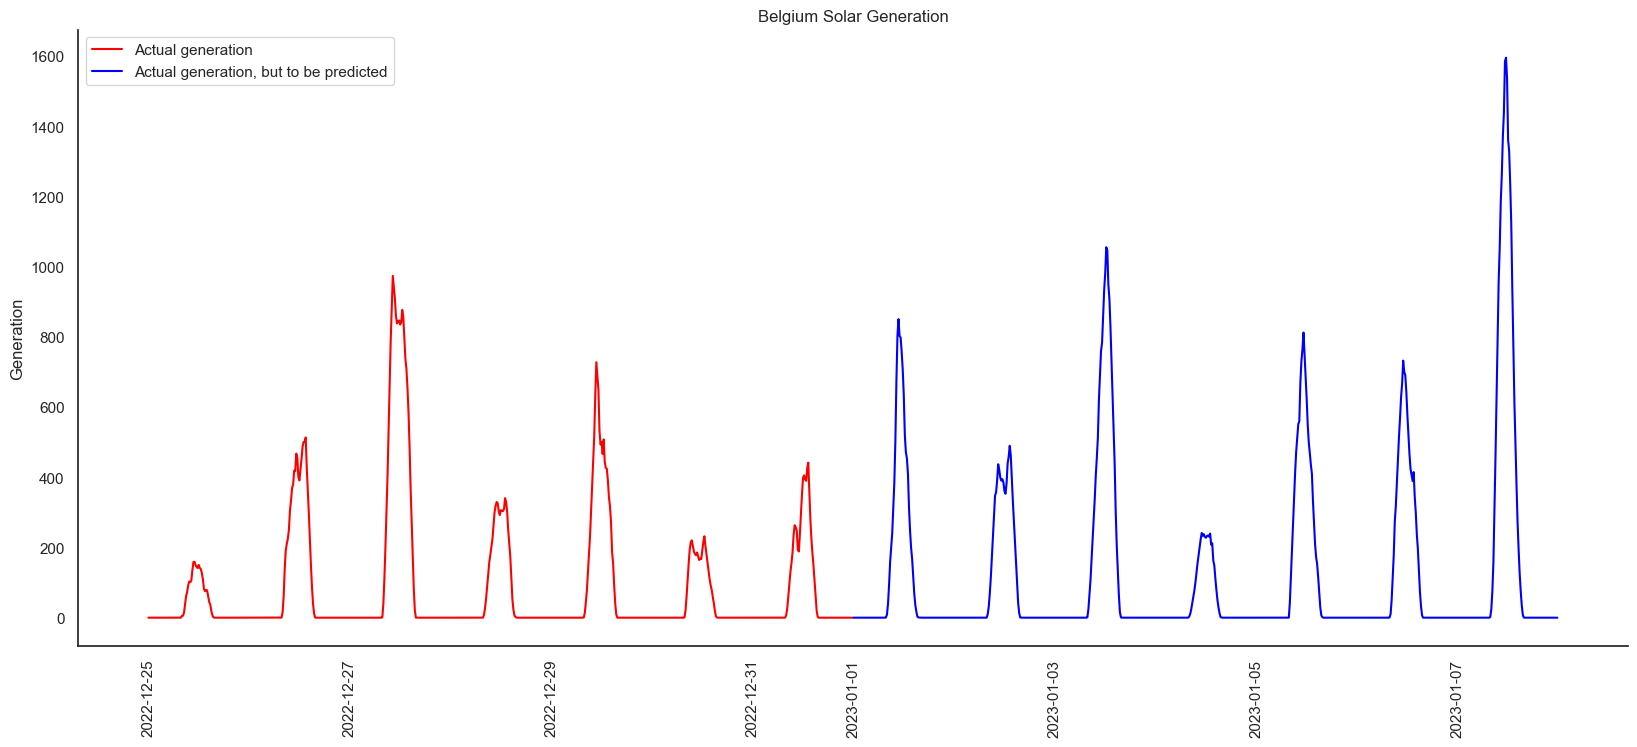

In [13]:
df_tf = df_be[['measured']].copy()
df_tf['day_of_year'] = df_tf.index.dayofyear / 365.0
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf.index.hour / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf.index.hour / 24)
df_tf_prescaled = df_tf.copy()

start_date = pd.to_datetime(start).tz_localize('UTC')
end_backward = start_date - pd.Timedelta(minutes=15)
start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)

df_tf_bwd = df_tf_prescaled[start_backward:end_backward]
df_tf_fwd = df_tf_prescaled[start_date:end_forward]
df_tf_all = df_tf_prescaled[start_backward:end_forward]

plt.figure(figsize=(20,8))
sns.lineplot(df_tf_bwd.measured, color='red', label='Actual generation')
sns.lineplot(df_tf_fwd.measured, color='blue', label='Actual generation, but to be predicted')
sns.despine()
plt.title('Belgium Solar Generation')
plt.xlabel('')
plt.ylabel('Generation')
# plt.xlim(pd.to_datetime('2023-05-26'), pd.to_datetime('2023-06-07'))
plt.xticks(rotation=90)
plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])

seq_len = 96
num_features = len(df_tf_bwd.columns)

X, y = [], []
for i in range(seq_len, len(df_tf_bwd)):
    X.append(df_tf_bwd.iloc[i-seq_len:i].values)
    y.append(df_tf_bwd.iloc[i]['measured'])

X, y = np.array(X), np.array(y)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_17496\2734455725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])


In [15]:
model1 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model2 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model3 = Sequential([
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model4 = Sequential([
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model5 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model6 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model7 = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(seq_len, num_features)),
    Dropout(0.2),
    Bidirectional(LSTM(50, kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    Dense(1)
])

models = {1:model1, 2:model2, 3:model3, 4:model4, 5:model5, 6:model6, 7:model7}
# models = {1:model1}

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
scores = []

for model_num, model in models.items():
    print(f'Fitting model {model_num}')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    scores.append({
        'model': model_num,
        'loss': history.history['loss'][-1], 
        'val_loss': history.history['val_loss'][-1],
        'delta': abs(history.history['loss'][-1] - history.history['val_loss'][-1])
    })

scores_df = pd.DataFrame(scores).sort_values('loss')
display(scores_df)

best_model_num = int(scores_df.iloc[0]['model'])
best_model = models[best_model_num]
best_model.save(f'{tf_file_title}_model{best_model_num}.h5')

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7


model      loss  val_loss     delta
0      1  0.004010  0.002072  0.001939
2      3  0.005051  0.002453  0.002599
3      4  0.005239  0.001593  0.003646
6      7  0.007296  0.005952  0.001344
4      5  0.008892  0.003716  0.005176
1      2  0.008939  0.002538  0.006401
5      6  0.011185  0.002765  0.008420

In [16]:
# best_model = load_model('best_model.h5')

### Predict

In [17]:
last_sequence = df_tf_bwd[-seq_len:].values
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))

days_to_predict = pred
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
    predicted_value = best_model.predict(last_sequence, verbose=0)
    predicted_values.append(predicted_value[0, 0])
    
    next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
    next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])

    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)

predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

predicted_values_bak = predicted_values.copy()

Predicting values: 100%|██████████| 672/672 [00:51<00:00, 13.05it/s]


In [29]:
predicted_values = predicted_values_bak.copy()

### Analysis

MSE	214.77160692242
MSE	136761.691700557
R^2	-0.8488704864656511


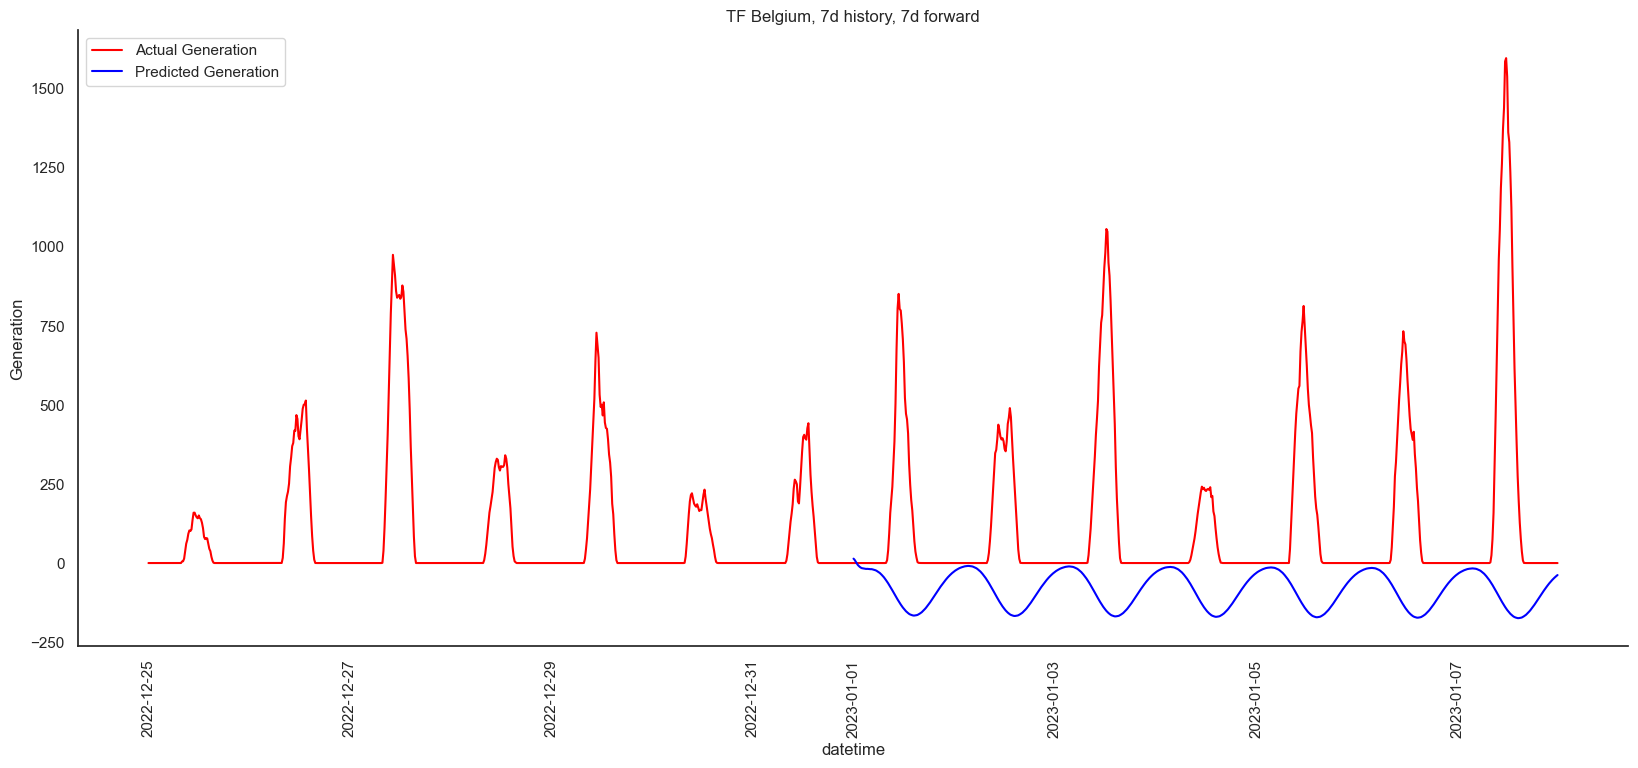

In [30]:
print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')

plt.figure(figsize=(20,8))

sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')

# predicted_values = np.maximum(predicted_values, 0)

shift_amount = 0
crop_amount = 0
scale = 1

predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15) + pd.Timedelta(hours=shift_amount), periods=len(predicted_values), freq='15min')
predicted_values_cropped = scale*predicted_values[crop_amount:]
predicted_index_cropped = predicted_index[crop_amount:]

sns.lineplot(x=predicted_index_cropped, y=predicted_values_cropped.flatten(), label='Predicted Generation', color='blue')
# plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2025-01-01'))
sns.despine()
plt.ylabel('Generation')
plt.xticks(rotation=90)
plt.title(tf_plot_title)
plt.savefig(tf_file_title, bbox_inches='tight', transparent=True)
plt.show()

# Model imports and predictions

In [20]:
# model_auto_daily_1h = pickle.load(open('ods032_model_auto_daily_1h.pkl','rb'))
# model_auto_daily_2h = pickle.load(open('ods032_model_auto_daily_2h.pkl','rb'))
# model_auto_daily_4h = pickle.load(open('ods032_model_auto_daily_4h.pkl','rb'))
# model_auto_weekly_1h = pickle.load(open('ods032_model_auto_weekly_1h.pkl','rb'))
# model_auto_weekly_2h = pickle.load(open('ods032_model_auto_weekly_2h.pkl','rb'))
# model_auto_weekly_4h = pickle.load(open('ods032_model_auto_weekly_4h.pkl','rb'))

In [21]:
# df_auto_daily_pred_1h = pd.DataFrame(model_auto_daily_1h.predict(n_periods=24*duration_forward))
# df_auto_daily_pred_1h = df_auto_daily_pred_1h.clip(lower=0)
# df_auto_daily_pred_2h = pd.DataFrame(model_auto_daily_2h.predict(n_periods=12*duration_forward))
# df_auto_daily_pred_2h = df_auto_daily_pred_2h.clip(lower=0)
# df_auto_daily_pred_4h = pd.DataFrame(model_auto_daily_4h.predict(n_periods=6*duration_forward))
# df_auto_daily_pred_4h = df_auto_daily_pred_4h.clip(lower=0)
# df_auto_weekly_pred_1h = pd.DataFrame(model_auto_weekly_1h.predict(n_periods=24*duration_forward))
# df_auto_weekly_pred_1h = df_auto_weekly_pred_1h.clip(lower=0)
# df_auto_weekly_pred_2h = pd.DataFrame(model_auto_weekly_2h.predict(n_periods=12*duration_forward))
# df_auto_weekly_pred_2h = df_auto_weekly_pred_2h.clip(lower=0)
# df_auto_weekly_pred_4h = pd.DataFrame(model_auto_weekly_4h.predict(n_periods=6*duration_forward))
# df_auto_weekly_pred_4h = df_auto_weekly_pred_4h.clip(lower=0)

# Combining models

In [22]:
# # convert all prediction dfs to hourly
# df_auto_daily_pred_2h_temp, _, _ = resample_h(df_auto_daily_pred_2h,1)
# df_auto_daily_pred_2h_temp = df_auto_daily_pred_2h_temp.ffill().bfill()

# # combine with weights
# df_auto_pred_combined = pd.DataFrame(0.5*df_auto_daily_pred_2h_temp + 0.5*df_auto_daily_pred_1h)
# df_auto_pred_combined = df_auto_pred_combined.clip(lower=0)

# plt.figure(figsize=(20,8))
# sns.lineplot(df_forward.measured.iloc[:96*5], color = 'black', label='Actual')
# sns.lineplot(df_forward.forecast_week, color='green', alpha=0.5, label='Their week-ahead forecast')
# sns.lineplot(df_auto_pred_4h[0], color = 'pink', alpha=0.5, label='My 151d forecast, 4h')
# sns.lineplot(df_auto_weekly_pred_4h[0], alpha=0.5, label='My weekly forecast, 4h') # terrible
# sns.lineplot(df_auto_weekly_pred_2h[0], alpha=0.5, label='My weekly forecast, 2h') # terrible
# sns.lineplot(df_auto_weekly_pred_1h[0], alpha=0.5, label='My weekly forecast, 1h') # terrible
# sns.lineplot(df_auto_daily_pred_4h[0], alpha=0.5, label='My daily forecast, 4h')
# sns.lineplot(df_auto_daily_pred_2h[0], alpha=0.5, label='My daily forecast, 2h')
# sns.lineplot(df_auto_daily_pred_1h[0], alpha=0.5, label='My daily forecast, 1h')
# sns.lineplot(df_auto_pred_combined[0].iloc[:120], alpha=0.5, label='My daily forecast, combined')
# plt.legend()
# plt.show()

# result = pd.concat([df_forward.resample('1h').mean().iloc[:120], df_auto_pred_combined.iloc[:120]], axis=1)
# result = result.bfill()
# result = result.ffill()
# result = result.rename(columns={0:'prediction'})
# result['error_mine'] = result.measured - result.prediction
# result['error_forecast_week'] = result.measured - result.forecast_week
# print(f'Mean\t\t{round(result.prediction.mean(),2)}')
# print(f'Median\t\t{round(result.prediction.median(),2)}')
# print(f'Mode\t\t{round(result.prediction.mode()[0],2)}')
# print(f'Std Dev\t\t{round(result.prediction.std(),2)}')
# print(f'Mean Error\t{round(result.error_mine.mean(),2)}')
# print(f'Median Error\t{round(result.error_mine.median(),2)}')
# print(f'Mode Error\t{round(result.error_mine.mode()[0],2)}')
# print(f'Error Std Dev\t{round(result.error_mine.std(),2)}')
# print(f'Max Error\t{round(abs(result.error_mine).max(),2)}')
# print(f'MAE\t\t{round(mean_absolute_error(result.measured, result.prediction),2)}')
# print(f'MSE\t\t{round(mean_squared_error(result.measured, result.prediction),2)}')
# print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(result.measured, result.prediction)),2)}')
# mape = np.where(result.measured != 0, np.abs(result.error_mine / result.measured) * 100, 0)
# print(f'MA%E\t\t{round(np.mean(mape), 2)}')
# print(f'R²\t\t{round(r2_score(result.measured, result.prediction),2)}')